# Simulated 4D-STEM Data: Large FOV Single Ripple Structure

In [496]:
# Import the python script containing the helper functions and classes
from fourdenoise import *
from ase.io import read
from abtem import *
from abTEM_helpers import * # module containing abTEM wrapper functions
import warnings
warnings.filterwarnings("ignore", message="Overspecified grid, the provided sampling is ignored")

# Using 'Arial' font for plots
plt.rcParams['font.family'] = 'Arial'

In [2]:
import os
import sys
os.chdir("C:/Users/haloe/Documents/CodeWriting/4Denoise/helpers")
sys.path.append("C:/Users/haloe/Documents/CodeWriting/4Denoise/")

os.getcwd()

'C:\\Users\\haloe\\Documents\\CodeWriting\\4Denoise\\helpers'

### Load the atomic model and create a lattice

**Note:** We downloaded the `.cif` file of experimentally-verified $\text{MoSe}_2$ from [Materials Project](https://next-gen.materialsproject.org/materials/mp-1634?chemsys=Mo-Se). This model is for bilayer $\text{MoSe}_2$. To obtain the monolayer version, we used the software [VESTA](https://jp-minerals.org/vesta/en/download.html) to modify the cell. We provide the resulting model in `MoSe2_monolayer.cif`

In [480]:
atoms = read("./MoSe2_monolayer.cif")
atoms

Atoms(symbols='MoSe2', pbc=True, cell=[[3.32226, 0.0, 0.0], [-1.6611299999999993, 2.877161557976889, 0.0], [0.0, 0.0, 13.542956]], spacegroup_kinds=...)

We need to **orthogonalize** the cell for the multislice method to work. See section titled "*Orthogonal and periodic supercells*" under [Advanced Atomic Models](https://abtem.readthedocs.io/en/latest/user_guide/tutorials/advanced_atomic_models.html).

Additional transformations:
Euler angles (degrees): 	 x = 0.000, 	 y = -0.000, 	 z = -0.000
Normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = 0.000
Shear strains (percent): 	 xy = -0.000, 	 xz = 0.000, 	 xz = 0.000


(<Figure size 1200x400 with 2 Axes>,
 <Axes: title={'center': 'Side view of $MoSe_2$ Lattice'}, xlabel='x [Å]', ylabel='z [Å]'>)

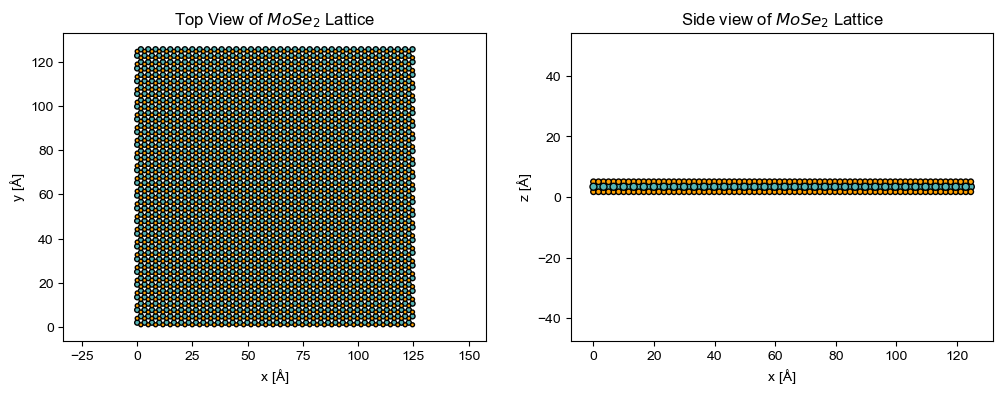

In [222]:
unit_cell_length = atoms.cell[0,0] # angstroms (alternatively, user can manually define the unit cell length)

# Define the approximate scale of the ripple model in angstroms per pixel
scale = 25 # Ang/px

# Repeat atom cell and orthogonalize it, as required by the multislice algorithm
atoms_orthogonalized, transform = orthogonalize_cell(atoms, return_transform=True)

from abtem.atoms import pretty_print_transform
print("Additional transformations:")
pretty_print_transform(transform)

n = 15
repetitions = (round(2.5*n), round(1.5*n), 1) # the (x, y, z) number of repetitions of the unit cell, we want it to be ~square-shaped
mose2_lattice = atoms_orthogonalized*repetitions

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
show_atoms(mose2_lattice, ax=ax1, title=r'Top View of $MoSe_2$ Lattice',show_cell=False, )
show_atoms(mose2_lattice, ax=ax2, plane='xz', title=r'Side view of $MoSe_2$ Lattice', show_cell=False )

In [12]:
# (Optional) Save the lattice to avoid rerunning the above
mose2_lattice.write('./mose2_lattice.cif', format='cif')

### Test *abTEM* electron diffraction simulations using lattice 

We define the variables $(\phi, \theta)$, where: 

* $\theta$ represents the **tilt** and 

* $\phi$ the **tilt axis** around which the tilt is measured from.

See figure below. These variables will be used to tilt the lattice and obtain the corresponding diffraction patterns.

We use the helper `rot_lattice` to apply three rotations in a fixed order. First, set the **tilt direction** with `phi_rot` (the in-plane azimuth that chooses the tilt axis). Next, apply the **tilt magnitude** with `theta_tilt` (the elevation angle—how far the lattice tips out of the xy-plane about that axis). Finally, `rotZ` makes any extra **spin about the z-axis** after the tilt.


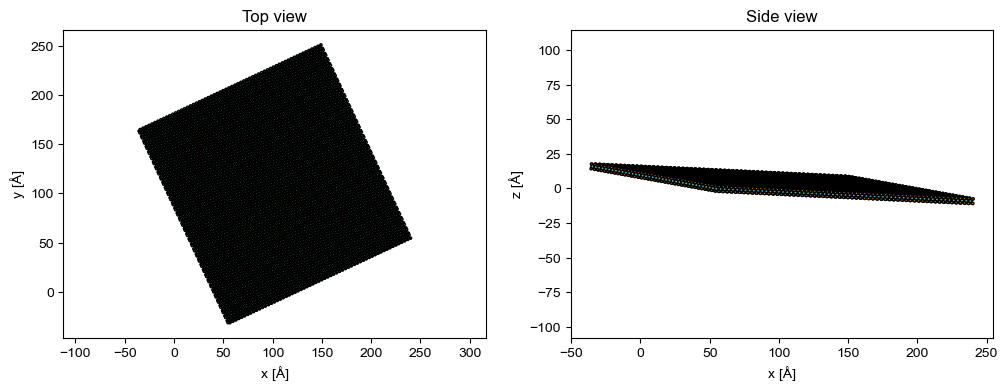

In [204]:
rot_lattice(mose2_lattice, theta_tilt=5, phi_rot=30, rotZ=25, cou=True, units='deg',)
plt.show()

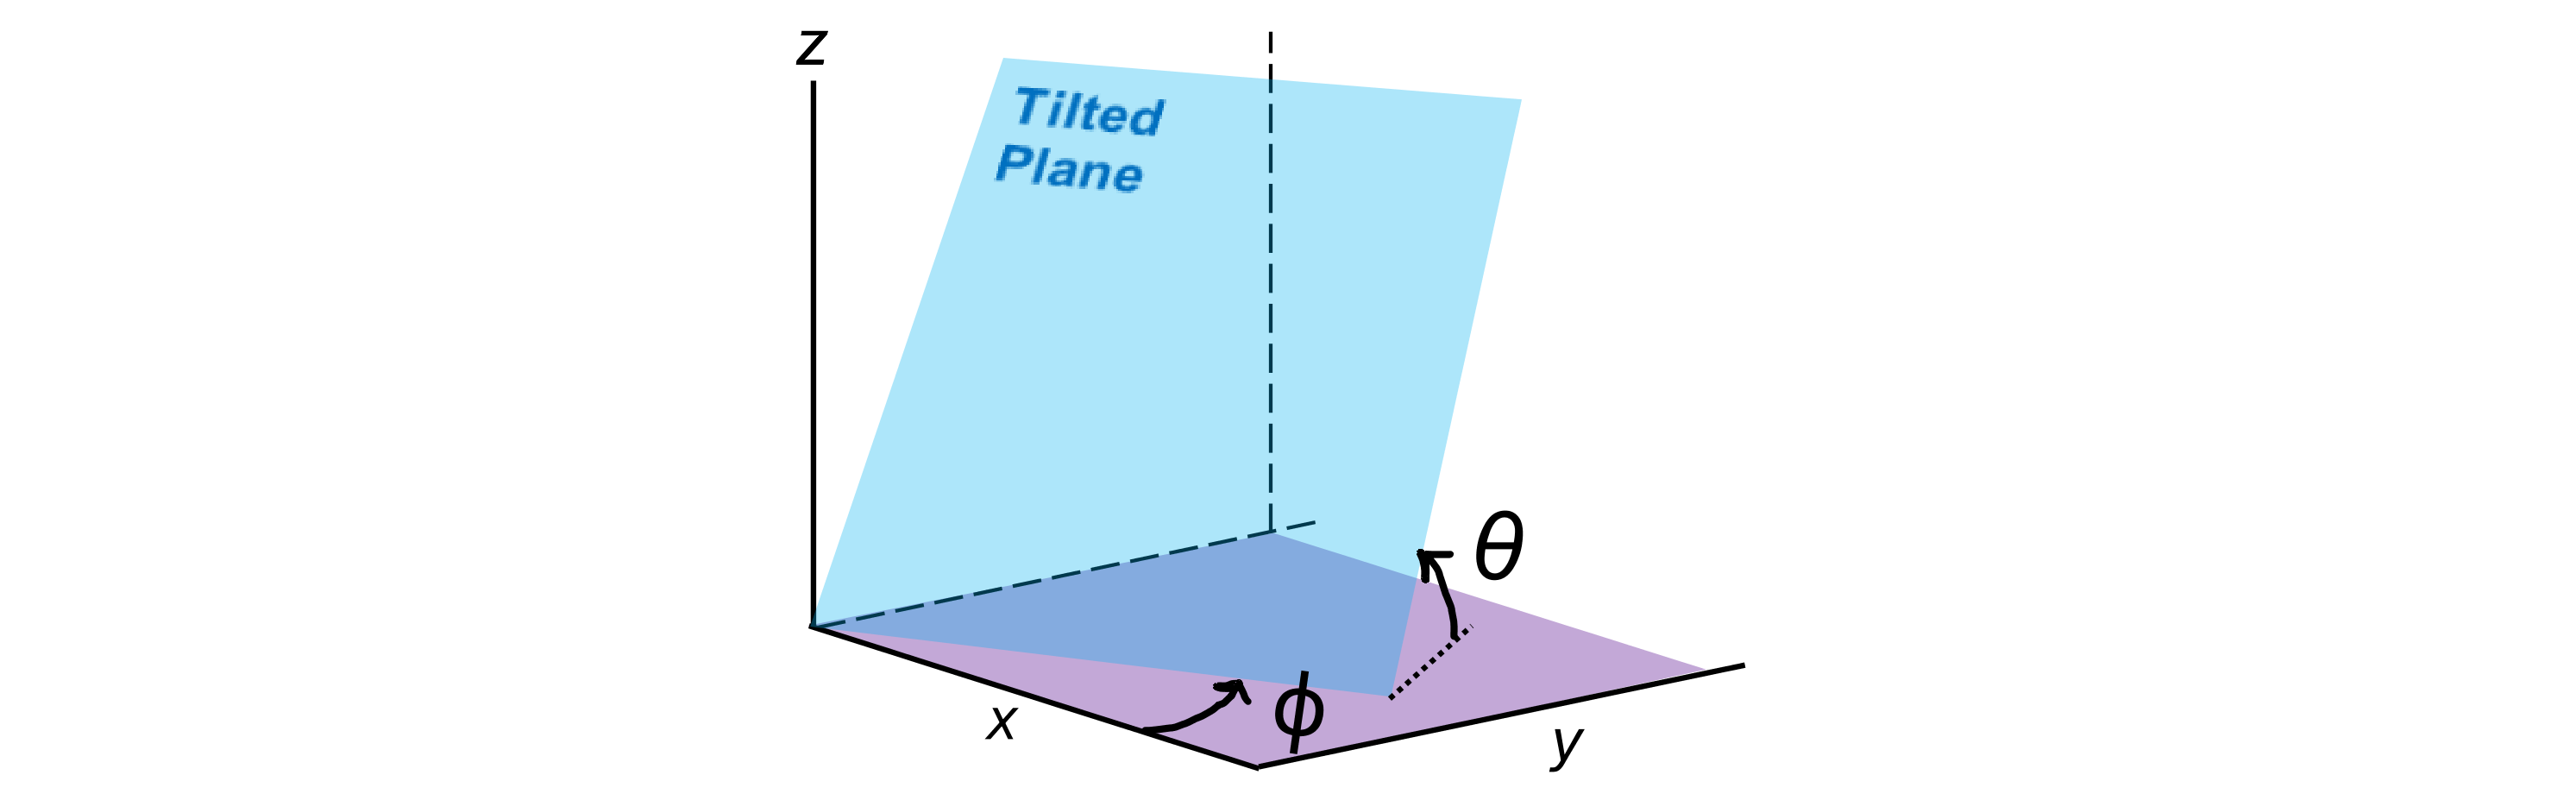

We simulate diffraction patterns in a "flat" and "tilted" configuration for MoSe$_2$ and obtain the probe shape as well.

[########################################] | 100% Completed | 113.44 ms
Probe FWHM = 14.232312202453613 Å
[########################################] | 100% Completed | 3.66 sms
[########################################] | 100% Completed | 6.92 sms


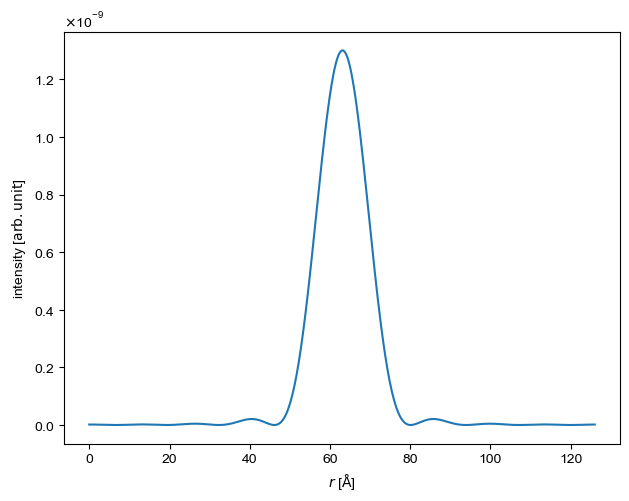

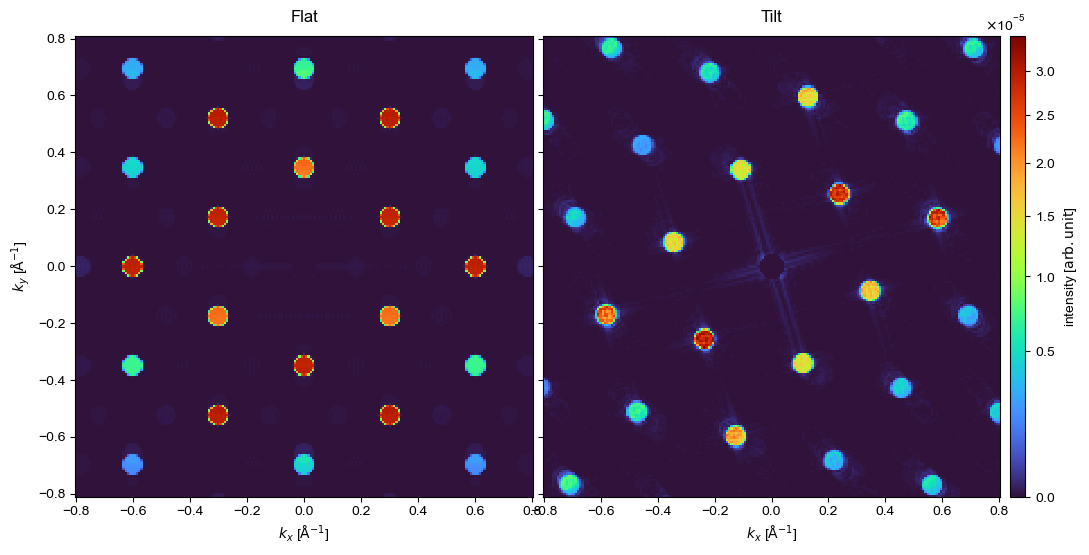

In [497]:
dp_flat = simulate_diff(mose2_lattice, 
                        theta_tilt=0, 
                        phi_rot=0, 
                        rotZ=0, 
                        energy=80e3, 
                        semiangle_cutoff=1.5, 
                        sampling_potential=0.2, 
                        slice_thickness=0.5,
                        sampling_probe=0.2, 
                        gpts=2**8.905, 
                        device='gpu', # alternatively, use 'cpu'
                        max_angle=33.6, 
                        units='deg',
                        get_probe_info=True,)

dp_tilt = simulate_diff(mose2_lattice, 
                        theta_tilt=15, # Arbitrary user choice just for visualization [0°, 25°]
                        phi_rot=25,    # Arbitrary user choice just for visualization [0°, 360°]
                        rotZ=17,       # Arbitrary user choice just for visualization [0°, 360°]
                        energy=80e3, 
                        semiangle_cutoff=1.5, 
                        sampling_potential=0.2, 
                        slice_thickness=0.5,
                        sampling_probe=0.2, 
                        gpts=2**8.905, 
                        device='gpu', # alternatively, use 'cpu'
                        max_angle=33.6, 
                        units='deg',
                        get_probe_info=False,)


diffraction_patterns = stack(
                                [
                                dp_flat.compute().block_direct(),
                                dp_tilt.compute().block_direct(),
                                ],
                                ("Flat", "Tilt"),
                            )

diffraction_patterns.show(
                             explode=True,
                             power=0.6,
                             figsize=(10*1.2, 6*1.2),
                             cbar=True,
                             common_color_scale=True,
                             cmap='turbo',
                         );



### Generate a geometric ripple and obtain its corresponding tilt maps

In [9]:
# Load the ripple model and abTEM helper functions
from rippleModel import * # ripple, calculate_surface_tilt, phplot

We begin by modeling a **geometric ripple**, which is a common formation in lateral heterojunctions of materials with significant lattice mismatch.

In [10]:
# Run this to see the docstring describing the influence of each of the model's parameters.
ripple?

Signature:
ripple(
    t=3.5,
    n=25.0,
    k=4.6,
    m=3,
    p=4.2,
    res=1,
    show_ripple_data=True,
    crop_size=None,
    return_full_ripple=True,
)
Docstring:
Generates a symmetrical ripple pattern based on mathematical transformations.

This function creates a ripple effect using trigonometric manipulations,
where parameters control various aspects of the ripple's appearance such as
width, sharpness, and edge characteristics. The ripple is symmetrically
reflected to form a full pattern.

Parameters
----------
t : float
    Influences the width of each ripple along the x-axis. Higher 't' values
    result in wider ripples. Default is 3.5.
n : float
    Controls the sharpness of the amplitude decrease in a direction parallel
    to the ripple. Higher 'n' results in a more rectangular ripple (as 
    viewed from the side). Default is 25.
k : float
    Affects the widening of the ripple ends. Higher 'k' values result in wider
    ripple ends, while lower values result in no 

In [11]:
# Run the ripple model to visualize it
ripple_map = ripple(t=3, n=25, k=4.6, m=3, p=4.2, res=1, show_ripple_data=False, crop_size=3)*1.31 # We multiply 1.31 to enhance the maximum tilt 

Visualize the ripple height map

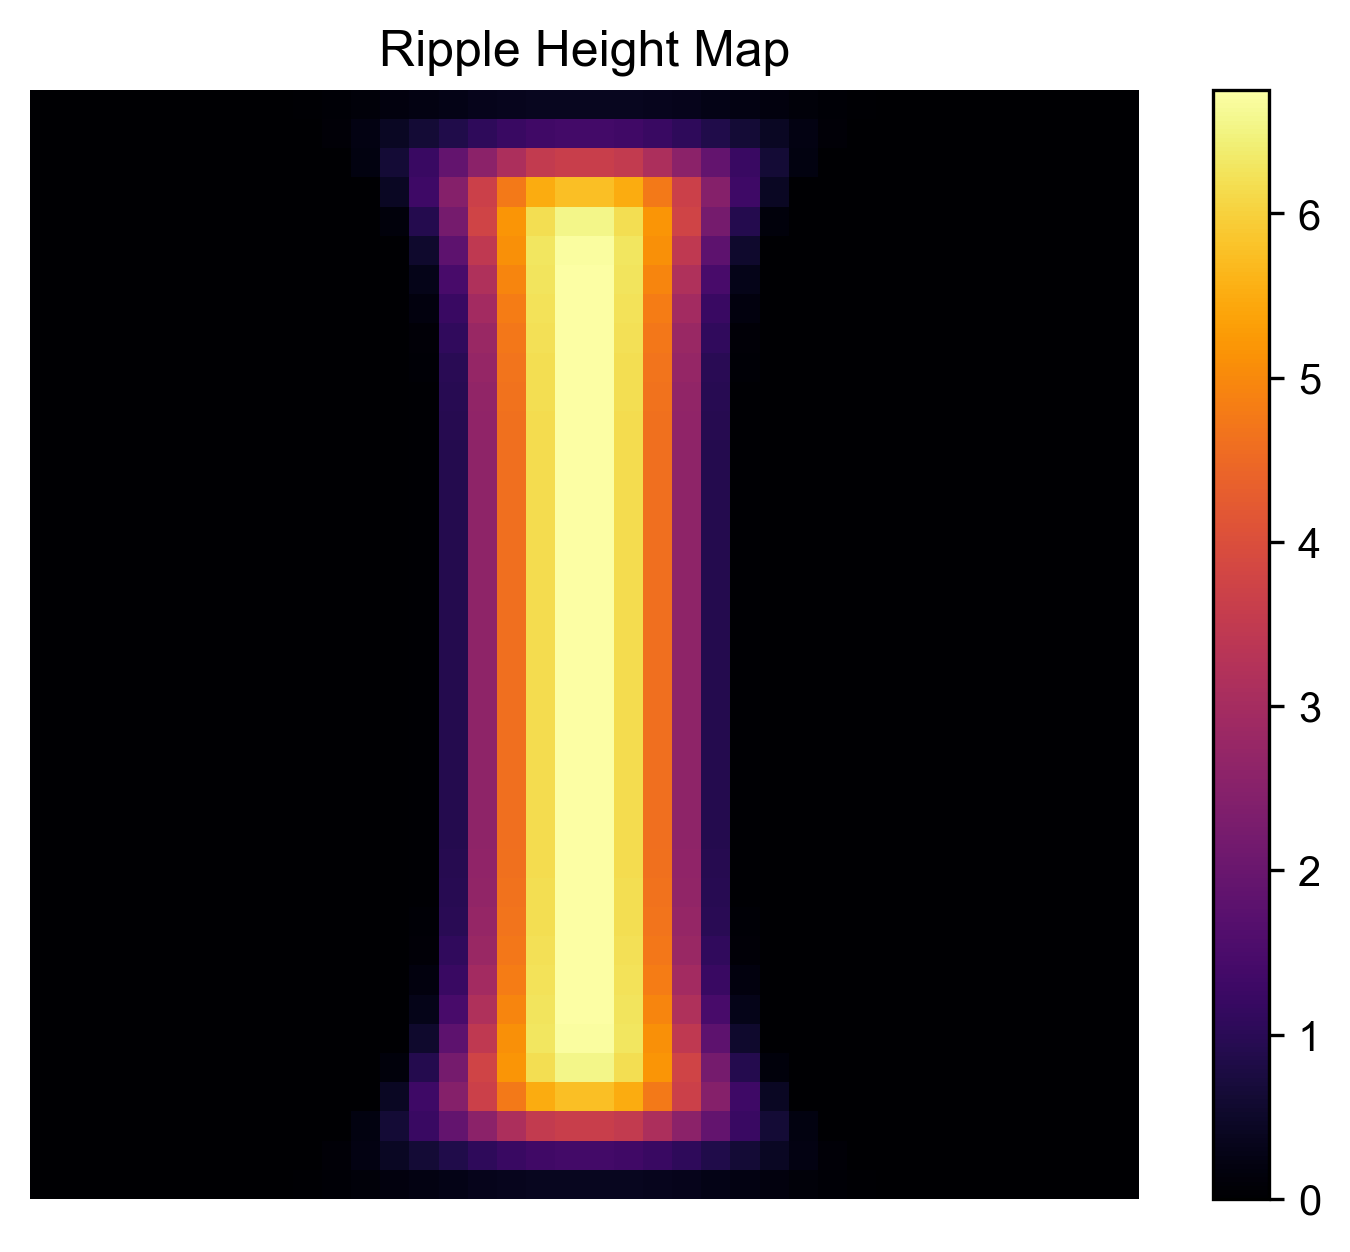

In [507]:
scale = 5.152 #nm/px

plt.figure(dpi=300)
plt.imshow(rotate(ripple_map,0)*scale, cmap='inferno')
plt.colorbar()
plt.title("Ripple Height Map")
plt.axis(False)
plt.show()

In [142]:
# Save the generated ripple 
np.save('geometric_ripple.npy', ripple_map)
# ripple_map = np.load('geometric_ripple.npy')

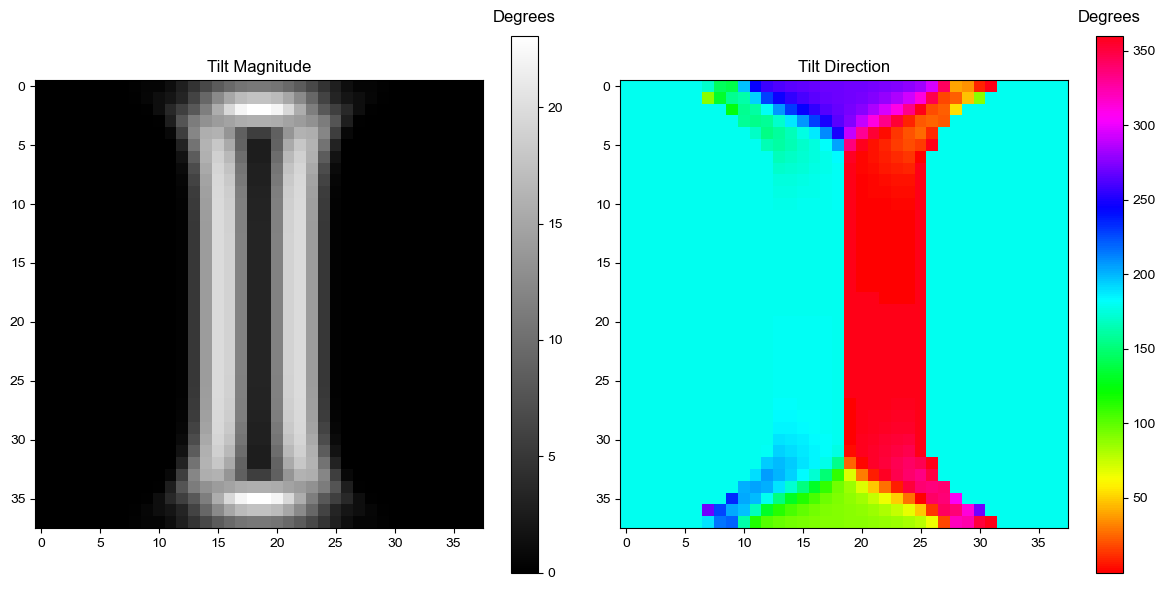

In [240]:
# We now collect the tilt and tilt-axis arrays from the simulated ripple array. This will serve to specify specific orientations
# for simulating diffraction patterns and obtaining a 4D dataset.

ripple_tilt, ripple_tilt_axis = calculate_surface_tilt(ripple_map, units='deg', show_results=True, )

# optionally, save the data
np.save('phi_geometric_ripple.npy', ripple_tilt_axis)
np.save('theta_geometric_ripple.npy', ripple_tilt)

In [241]:
ripple_tilt_axis -= 360 
ripple_tilt_axis += 90

In [16]:
phplot?

Signature: phplot(field1, Amp='raw', scale=True, subplot=True)
Docstring:
Visualize the phase and amplitude of a field as an RGB image and optionally display a color wheel.

Parameters
----------
field1 : complex ndarray or tuple
    The input field. Can be a complex array or a tuple of (phase, magnitude).
Amp : str, optional
    Control for amplitude visualization:
    'uniform' - use a uniform amplitude across the image,
    'log' - use logarithmic scaling of the amplitude,
    'raw' - use the raw amplitude values.
scale : bool, optional
    If True, plots a color wheel with corresponding phase hues. Default is False.
subplot : bool, optional
    If True, uses subplots to show the image and color wheel; otherwise, separate figures.

Returns
-------
rgb_image : ndarray
    An array representing the RGB visualization of the input field.

Notes
-----
This code is based on the MATLAB code written by [author] in [date].
File:      c:\users\haloe\documents\codewriting\4denoise\helpers\ripp

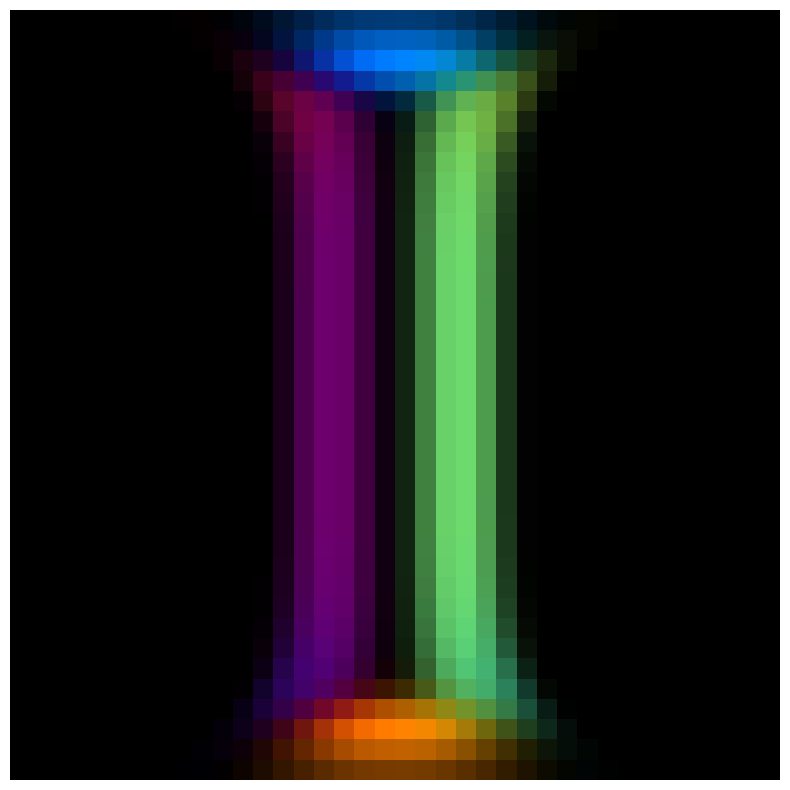

C:\Users\haloe\Documents\CodeWriting\4Denoise\helpers\rippleModel.py:293: RuntimeWarning: invalid value encountered in cast
  idx = np.clip(((hue + np.pi) / (2 * np.pi) * 255).astype(int), 0, 255)


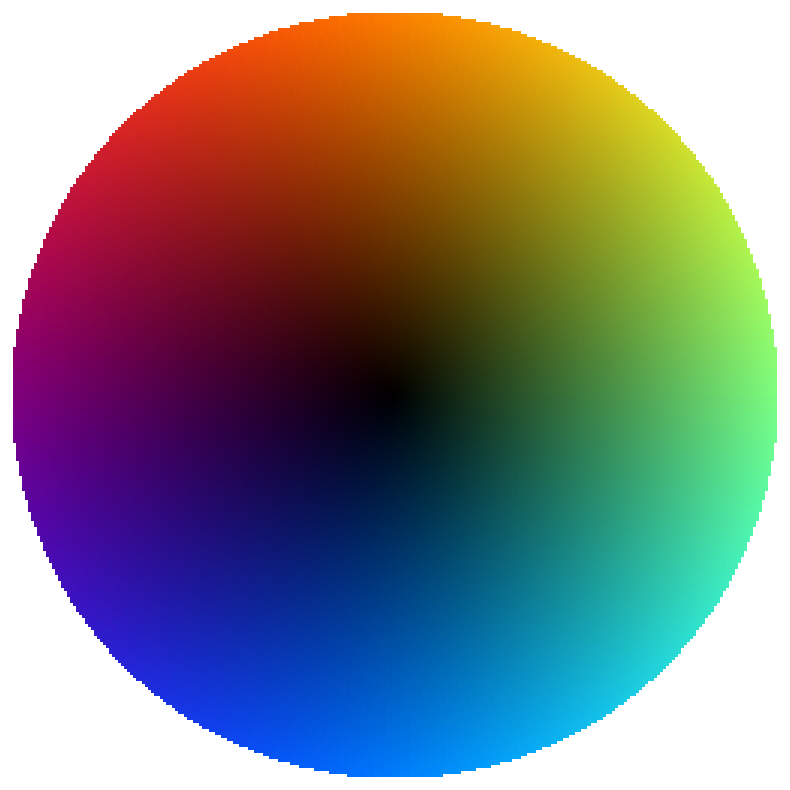

In [17]:
# Visualize a plot of combined amplitude and phase. 
phplot((np.radians(ripple_tilt_axis), ripple_tilt), Amp='raw', scale=True, subplot=False);

### Generate a 4D dataset using the ripple's tilt data

**Note:** We must initialize a 4D array that matches the real-space shape of the ripple and the reciprocal-space of the diffraction patterns. For the reciprocal-space, we use the dimensions of the diffraction patterns we simulated above (`dp_flat` and `dp_tilt`).

In [254]:
ky, kx = dp_flat.array.shape
ny, nx = ripple_map.shape

# Initialize simulated 4D dataset
ripple_dataset = np.zeros((ny, nx, ky, kx), dtype=np.float32)

dataset_list = []

for y in tqdm(range(ny)):
    for x in range(nx):
        
        theta, phi = (ripple_tilt[y, x], ripple_tilt_axis[y, x])
                
        tilted_diffraction = simulate_diff(mose2_lattice, theta_tilt=theta, phi_rot=phi, rotZ=0, energy=80e3, 
                              semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
                              sampling_probe=0.2, gpts=2**8.905, device='gpu', max_angle=33.6, units='deg')    
        
        # Resize to square matrix and add to 4D dataset
        ripple_dataset[y, x] = tilted_diffraction.compute().array

        dataset_list += [tilted_diffraction]

# Optionally, save the 4D dataset
np.save('simulated_4d_dataset_highRes_2.npy', ripple_dataset)

  0%|                                                                                           | 0/38 [00:00<?, ?it/s]

[########################################] | 100% Completed | 2.81 sms
[########################################] | 100% Completed | 4.35 sms
[########################################] | 100% Completed | 3.68 sms
[########################################] | 100% Completed | 3.79 sms
[########################################] | 100% Completed | 2.29 sms
[########################################] | 100% Completed | 2.52 sms
[########################################] | 100% Completed | 1.74 sms
[########################################] | 100% Completed | 2.46 sms
[########################################] | 100% Completed | 2.48 sms
[########################################] | 100% Completed | 2.36 sms
[########################################] | 100% Completed | 2.48 sms
[########################################] | 100% Completed | 2.83 sms
[########################################] | 100% Completed | 4.24 sms
[########################################] | 100% Completed | 4.92 sms
[#####

  3%|██                                                                              | 1/38 [02:06<1:17:58, 126.44s/it]

[########################################] | 100% Completed | 3.72 sms
[########################################] | 100% Completed | 2.94 sms
[########################################] | 100% Completed | 3.70 sms
[########################################] | 100% Completed | 2.39 sms
[########################################] | 100% Completed | 2.94 sms
[########################################] | 100% Completed | 4.12 sms
[########################################] | 100% Completed | 4.10 sms
[########################################] | 100% Completed | 2.30 sms
[########################################] | 100% Completed | 4.00 sms
[########################################] | 100% Completed | 4.24 sms
[########################################] | 100% Completed | 3.89 sms
[########################################] | 100% Completed | 3.04 sms
[########################################] | 100% Completed | 4.06 sms
[########################################] | 100% Completed | 2.91 sms
[#####

  5%|████▏                                                                           | 2/38 [04:18<1:17:40, 129.47s/it]

[########################################] | 100% Completed | 2.37 sms
[########################################] | 100% Completed | 2.25 sms
[########################################] | 100% Completed | 2.26 sms
[########################################] | 100% Completed | 2.67 sms
[########################################] | 100% Completed | 2.36 sms
[########################################] | 100% Completed | 2.46 sms
[########################################] | 100% Completed | 2.46 sms
[########################################] | 100% Completed | 2.46 sms
[########################################] | 100% Completed | 2.57 sms
[########################################] | 100% Completed | 2.48 sms
[########################################] | 100% Completed | 2.47 sms
[########################################] | 100% Completed | 2.59 sms
[########################################] | 100% Completed | 2.78 sms
[########################################] | 100% Completed | 2.89 sms
[#####

  8%|██████▎                                                                         | 3/38 [06:00<1:08:19, 117.13s/it]

[########################################] | 100% Completed | 2.91 sms
[########################################] | 100% Completed | 2.69 sms
[########################################] | 100% Completed | 2.38 sms
[########################################] | 100% Completed | 3.69 sms
[########################################] | 100% Completed | 2.39 sms
[########################################] | 100% Completed | 3.92 sms
[########################################] | 100% Completed | 2.29 sms
[########################################] | 100% Completed | 3.69 sms
[########################################] | 100% Completed | 2.32 sms
[########################################] | 100% Completed | 2.41 sms
[########################################] | 100% Completed | 4.03 sms
[########################################] | 100% Completed | 2.62 sms
[########################################] | 100% Completed | 4.12 sms
[########################################] | 100% Completed | 3.05 sms
[#####

 11%|████████▍                                                                       | 4/38 [08:00<1:07:03, 118.35s/it]

[########################################] | 100% Completed | 3.78 sms
[########################################] | 100% Completed | 2.62 sms
[########################################] | 100% Completed | 2.94 sms
[########################################] | 100% Completed | 2.60 sms
[########################################] | 100% Completed | 2.19 sms
[########################################] | 100% Completed | 4.48 sms
[########################################] | 100% Completed | 3.72 sms
[########################################] | 100% Completed | 2.83 sms
[########################################] | 100% Completed | 2.29 sms
[########################################] | 100% Completed | 3.05 sms
[########################################] | 100% Completed | 2.19 sms
[########################################] | 100% Completed | 3.25 sms
[########################################] | 100% Completed | 4.43 sms
[########################################] | 100% Completed | 4.01 sms
[#####

 13%|██████████▌                                                                     | 5/38 [10:13<1:07:57, 123.57s/it]

[########################################] | 100% Completed | 3.15 sms
[########################################] | 100% Completed | 2.39 sms
[########################################] | 100% Completed | 3.49 sms
[########################################] | 100% Completed | 3.92 sms
[########################################] | 100% Completed | 3.68 sms
[########################################] | 100% Completed | 2.07 sms
[########################################] | 100% Completed | 3.91 sms
[########################################] | 100% Completed | 3.56 sms
[########################################] | 100% Completed | 2.61 sms
[########################################] | 100% Completed | 2.83 sms
[########################################] | 100% Completed | 3.55 sms
[########################################] | 100% Completed | 3.59 sms
[########################################] | 100% Completed | 2.80 sms
[########################################] | 100% Completed | 3.79 sms
[#####

 16%|████████████▋                                                                   | 6/38 [12:25<1:07:22, 126.32s/it]

[########################################] | 100% Completed | 3.58 sms
[########################################] | 100% Completed | 2.51 sms
[########################################] | 100% Completed | 3.91 sms
[########################################] | 100% Completed | 2.30 sms
[########################################] | 100% Completed | 3.04 sms
[########################################] | 100% Completed | 2.32 sms
[########################################] | 100% Completed | 3.16 sms
[########################################] | 100% Completed | 3.41 sms
[########################################] | 100% Completed | 3.49 sms
[########################################] | 100% Completed | 3.34 sms
[########################################] | 100% Completed | 3.33 sms
[########################################] | 100% Completed | 3.22 sms
[########################################] | 100% Completed | 3.37 sms
[########################################] | 100% Completed | 4.54 sms
[#####

 18%|██████████████▋                                                                 | 7/38 [14:33<1:05:33, 126.89s/it]

[########################################] | 100% Completed | 4.29 sms
[########################################] | 100% Completed | 2.29 sms
[########################################] | 100% Completed | 3.16 sms
[########################################] | 100% Completed | 2.75 sms
[########################################] | 100% Completed | 2.77 sms
[########################################] | 100% Completed | 2.18 sms
[########################################] | 100% Completed | 3.13 sms
[########################################] | 100% Completed | 2.59 sms
[########################################] | 100% Completed | 3.77 sms
[########################################] | 100% Completed | 3.23 sms
[########################################] | 100% Completed | 4.90 sms
[########################################] | 100% Completed | 3.90 sms
[########################################] | 100% Completed | 3.93 sms
[########################################] | 100% Completed | 3.90 sms
[#####

 21%|████████████████▊                                                               | 8/38 [16:43<1:03:59, 127.98s/it]

[########################################] | 100% Completed | 2.51 sms
[########################################] | 100% Completed | 2.40 sms
[########################################] | 100% Completed | 3.90 sms
[########################################] | 100% Completed | 2.69 sms
[########################################] | 100% Completed | 2.80 sms
[########################################] | 100% Completed | 2.49 sms
[########################################] | 100% Completed | 3.36 sms
[########################################] | 100% Completed | 2.61 sms
[########################################] | 100% Completed | 2.42 sms
[########################################] | 100% Completed | 3.14 sms
[########################################] | 100% Completed | 2.95 sms
[########################################] | 100% Completed | 5.03 sms
[########################################] | 100% Completed | 2.16 sms
[########################################] | 100% Completed | 3.03 sms
[#####

 24%|██████████████████▉                                                             | 9/38 [18:53<1:02:09, 128.60s/it]

[########################################] | 100% Completed | 2.90 sms
[########################################] | 100% Completed | 3.65 sms
[########################################] | 100% Completed | 2.89 sms
[########################################] | 100% Completed | 2.08 sms
[########################################] | 100% Completed | 2.31 sms
[########################################] | 100% Completed | 2.34 sms
[########################################] | 100% Completed | 2.94 sms
[########################################] | 100% Completed | 2.71 sms
[########################################] | 100% Completed | 3.60 sms
[########################################] | 100% Completed | 4.89 sms
[########################################] | 100% Completed | 3.26 sms
[########################################] | 100% Completed | 2.15 sms
[########################################] | 100% Completed | 2.19 sms
[########################################] | 100% Completed | 4.13 sms
[#####

 26%|█████████████████████▎                                                           | 10/38 [21:01<59:53, 128.34s/it]

[########################################] | 100% Completed | 3.45 sms
[########################################] | 100% Completed | 2.63 sms
[########################################] | 100% Completed | 3.90 sms
[########################################] | 100% Completed | 3.81 sms
[########################################] | 100% Completed | 3.80 sms
[########################################] | 100% Completed | 2.84 sms
[########################################] | 100% Completed | 4.44 sms
[########################################] | 100% Completed | 3.92 sms
[########################################] | 100% Completed | 3.71 sms
[########################################] | 100% Completed | 3.51 sms
[########################################] | 100% Completed | 3.05 sms
[########################################] | 100% Completed | 2.30 sms
[########################################] | 100% Completed | 3.37 sms
[########################################] | 100% Completed | 3.62 sms
[#####

 29%|███████████████████████▍                                                         | 11/38 [23:12<58:06, 129.13s/it]

[########################################] | 100% Completed | 2.29 sms
[########################################] | 100% Completed | 3.69 sms
[########################################] | 100% Completed | 3.25 sms
[########################################] | 100% Completed | 2.07 sms
[########################################] | 100% Completed | 3.91 sms
[########################################] | 100% Completed | 2.84 sms
[########################################] | 100% Completed | 4.03 sms
[########################################] | 100% Completed | 2.42 sms
[########################################] | 100% Completed | 2.62 sms
[########################################] | 100% Completed | 3.34 sms
[########################################] | 100% Completed | 2.41 sms
[########################################] | 100% Completed | 4.68 sms
[########################################] | 100% Completed | 3.70 sms
[########################################] | 100% Completed | 3.35 sms
[#####

 32%|█████████████████████████▌                                                       | 12/38 [25:21<55:55, 129.07s/it]

[########################################] | 100% Completed | 2.39 sms
[########################################] | 100% Completed | 3.78 sms
[########################################] | 100% Completed | 3.68 sms
[########################################] | 100% Completed | 4.46 sms
[########################################] | 100% Completed | 3.80 sms
[########################################] | 100% Completed | 2.30 sms
[########################################] | 100% Completed | 2.30 sms
[########################################] | 100% Completed | 2.29 sms
[########################################] | 100% Completed | 4.09 sms
[########################################] | 100% Completed | 2.40 sms
[########################################] | 100% Completed | 3.04 sms
[########################################] | 100% Completed | 2.82 sms
[########################################] | 100% Completed | 2.83 sms
[########################################] | 100% Completed | 4.03 sms
[#####

 34%|███████████████████████████▋                                                     | 13/38 [27:29<53:40, 128.82s/it]

[########################################] | 100% Completed | 2.10 sms
[########################################] | 100% Completed | 3.37 sms
[########################################] | 100% Completed | 4.59 sms
[########################################] | 100% Completed | 3.47 sms
[########################################] | 100% Completed | 3.05 sms
[########################################] | 100% Completed | 2.31 sms
[########################################] | 100% Completed | 2.94 sms
[########################################] | 100% Completed | 2.93 sms
[########################################] | 100% Completed | 2.89 sms
[########################################] | 100% Completed | 3.67 sms
[########################################] | 100% Completed | 3.36 sms
[########################################] | 100% Completed | 4.24 sms
[########################################] | 100% Completed | 2.29 sms
[########################################] | 100% Completed | 4.02 sms
[#####

 37%|█████████████████████████████▊                                                   | 14/38 [29:33<50:56, 127.36s/it]

[########################################] | 100% Completed | 4.23 sms
[########################################] | 100% Completed | 2.21 sms
[########################################] | 100% Completed | 2.28 sms
[########################################] | 100% Completed | 2.95 sms
[########################################] | 100% Completed | 4.22 sms
[########################################] | 100% Completed | 2.62 sms
[########################################] | 100% Completed | 3.57 sms
[########################################] | 100% Completed | 3.32 sms
[########################################] | 100% Completed | 2.80 sms
[########################################] | 100% Completed | 3.77 sms
[########################################] | 100% Completed | 3.05 sms
[########################################] | 100% Completed | 2.86 sms
[########################################] | 100% Completed | 2.40 sms
[########################################] | 100% Completed | 2.60 sms
[#####

 39%|███████████████████████████████▉                                                 | 15/38 [31:44<49:16, 128.55s/it]

[########################################] | 100% Completed | 2.40 sms
[########################################] | 100% Completed | 5.13 sms
[########################################] | 100% Completed | 3.27 sms
[########################################] | 100% Completed | 3.01 sms
[########################################] | 100% Completed | 3.14 sms
[########################################] | 100% Completed | 2.92 sms
[########################################] | 100% Completed | 2.65 sms
[########################################] | 100% Completed | 4.22 sms
[########################################] | 100% Completed | 3.83 sms
[########################################] | 100% Completed | 3.91 sms
[########################################] | 100% Completed | 2.50 sms
[########################################] | 100% Completed | 2.30 sms
[########################################] | 100% Completed | 3.27 sms
[########################################] | 100% Completed | 3.67 sms
[#####

 42%|██████████████████████████████████                                               | 16/38 [34:00<47:56, 130.74s/it]

[########################################] | 100% Completed | 3.03 sms
[########################################] | 100% Completed | 3.25 sms
[########################################] | 100% Completed | 3.72 sms
[########################################] | 100% Completed | 2.43 sms
[########################################] | 100% Completed | 3.39 sms
[########################################] | 100% Completed | 3.71 sms
[########################################] | 100% Completed | 4.23 sms
[########################################] | 100% Completed | 3.13 sms
[########################################] | 100% Completed | 5.10 sms
[########################################] | 100% Completed | 4.67 sms
[########################################] | 100% Completed | 4.35 sms
[########################################] | 100% Completed | 3.76 sms
[########################################] | 100% Completed | 5.42 sms
[########################################] | 100% Completed | 3.18 sms
[#####

 45%|████████████████████████████████████▏                                            | 17/38 [36:16<46:20, 132.41s/it]

[########################################] | 100% Completed | 4.34 sms
[########################################] | 100% Completed | 3.27 sms
[########################################] | 100% Completed | 4.35 sms
[########################################] | 100% Completed | 2.84 sms
[########################################] | 100% Completed | 3.72 sms
[########################################] | 100% Completed | 3.48 sms
[########################################] | 100% Completed | 2.29 sms
[########################################] | 100% Completed | 4.32 sms
[########################################] | 100% Completed | 2.40 sms
[########################################] | 100% Completed | 4.02 sms
[########################################] | 100% Completed | 2.82 sms
[########################################] | 100% Completed | 2.70 sms
[########################################] | 100% Completed | 3.01 sms
[########################################] | 100% Completed | 3.99 sms
[#####

 47%|██████████████████████████████████████▎                                          | 18/38 [38:34<44:42, 134.10s/it]

[########################################] | 100% Completed | 3.95 sms
[########################################] | 100% Completed | 3.61 sms
[########################################] | 100% Completed | 2.61 sms
[########################################] | 100% Completed | 2.19 sms
[########################################] | 100% Completed | 4.46 sms
[########################################] | 100% Completed | 3.03 sms
[########################################] | 100% Completed | 3.13 sms
[########################################] | 100% Completed | 2.82 sms
[########################################] | 100% Completed | 3.90 sms
[########################################] | 100% Completed | 3.89 sms
[########################################] | 100% Completed | 4.66 sms
[########################################] | 100% Completed | 2.09 sms
[########################################] | 100% Completed | 4.90 sms
[########################################] | 100% Completed | 4.04 sms
[#####

 50%|████████████████████████████████████████▌                                        | 19/38 [40:54<43:00, 135.82s/it]

[########################################] | 100% Completed | 2.91 sms
[########################################] | 100% Completed | 3.24 sms
[########################################] | 100% Completed | 2.72 sms
[########################################] | 100% Completed | 3.25 sms
[########################################] | 100% Completed | 3.42 sms
[########################################] | 100% Completed | 2.87 sms
[########################################] | 100% Completed | 2.44 sms
[########################################] | 100% Completed | 4.69 sms
[########################################] | 100% Completed | 3.70 sms
[########################################] | 100% Completed | 2.41 sms
[########################################] | 100% Completed | 2.29 sms
[########################################] | 100% Completed | 3.36 sms
[########################################] | 100% Completed | 4.01 sms
[########################################] | 100% Completed | 3.37 sms
[#####

 53%|██████████████████████████████████████████▋                                      | 20/38 [43:00<39:49, 132.78s/it]

[########################################] | 100% Completed | 2.81 sms
[########################################] | 100% Completed | 2.82 sms
[########################################] | 100% Completed | 4.03 sms
[########################################] | 100% Completed | 3.59 sms
[########################################] | 100% Completed | 2.07 sms
[########################################] | 100% Completed | 3.48 sms
[########################################] | 100% Completed | 3.08 sms
[########################################] | 100% Completed | 3.38 sms
[########################################] | 100% Completed | 2.50 sms
[########################################] | 100% Completed | 2.19 sms
[########################################] | 100% Completed | 2.31 sms
[########################################] | 100% Completed | 3.26 sms
[########################################] | 100% Completed | 2.28 sms
[########################################] | 100% Completed | 2.94 sms
[#####

 55%|████████████████████████████████████████████▊                                    | 21/38 [45:06<37:05, 130.93s/it]

[########################################] | 100% Completed | 4.04 sms
[########################################] | 100% Completed | 2.72 sms
[########################################] | 100% Completed | 2.39 sms
[########################################] | 100% Completed | 4.15 sms
[########################################] | 100% Completed | 3.04 sms
[########################################] | 100% Completed | 2.32 sms
[########################################] | 100% Completed | 3.49 sms
[########################################] | 100% Completed | 4.46 sms
[########################################] | 100% Completed | 2.84 sms
[########################################] | 100% Completed | 2.40 sms
[########################################] | 100% Completed | 4.12 sms
[########################################] | 100% Completed | 3.79 sms
[########################################] | 100% Completed | 3.33 sms
[########################################] | 100% Completed | 3.06 sms
[#####

 58%|██████████████████████████████████████████████▉                                  | 22/38 [47:17<34:54, 130.91s/it]

[########################################] | 100% Completed | 2.28 sms
[########################################] | 100% Completed | 2.41 sms
[########################################] | 100% Completed | 3.47 sms
[########################################] | 100% Completed | 4.02 sms
[########################################] | 100% Completed | 3.49 sms
[########################################] | 100% Completed | 2.32 sms
[########################################] | 100% Completed | 3.72 sms
[########################################] | 100% Completed | 4.01 sms
[########################################] | 100% Completed | 2.50 sms
[########################################] | 100% Completed | 3.70 sms
[########################################] | 100% Completed | 3.80 sms
[########################################] | 100% Completed | 3.48 sms
[########################################] | 100% Completed | 3.14 sms
[########################################] | 100% Completed | 3.15 sms
[#####

 61%|█████████████████████████████████████████████████                                | 23/38 [49:21<32:13, 128.89s/it]

[########################################] | 100% Completed | 3.27 sms
[########################################] | 100% Completed | 3.80 sms
[########################################] | 100% Completed | 3.89 sms
[########################################] | 100% Completed | 2.53 sms
[########################################] | 100% Completed | 4.76 sms
[########################################] | 100% Completed | 2.96 sms
[########################################] | 100% Completed | 4.25 sms
[########################################] | 100% Completed | 3.48 sms
[########################################] | 100% Completed | 4.13 sms
[########################################] | 100% Completed | 3.14 sms
[########################################] | 100% Completed | 3.34 sms
[########################################] | 100% Completed | 3.89 sms
[########################################] | 100% Completed | 5.35 sms
[########################################] | 100% Completed | 4.88 sms
[#####

 63%|███████████████████████████████████████████████████▏                             | 24/38 [51:37<30:31, 130.84s/it]

[########################################] | 100% Completed | 3.80 sms
[########################################] | 100% Completed | 2.32 sms
[########################################] | 100% Completed | 4.03 sms
[########################################] | 100% Completed | 4.02 sms
[########################################] | 100% Completed | 2.81 sms
[########################################] | 100% Completed | 3.36 sms
[########################################] | 100% Completed | 3.24 sms
[########################################] | 100% Completed | 3.14 sms
[########################################] | 100% Completed | 2.40 sms
[########################################] | 100% Completed | 2.42 sms
[########################################] | 100% Completed | 3.27 sms
[########################################] | 100% Completed | 2.19 sms
[########################################] | 100% Completed | 3.05 sms
[########################################] | 100% Completed | 4.13 sms
[#####

 66%|█████████████████████████████████████████████████████▎                           | 25/38 [53:48<28:21, 130.91s/it]

[########################################] | 100% Completed | 2.83 sms
[########################################] | 100% Completed | 2.71 sms
[########################################] | 100% Completed | 3.33 sms
[########################################] | 100% Completed | 4.63 sms
[########################################] | 100% Completed | 3.22 sms
[########################################] | 100% Completed | 3.65 sms
[########################################] | 100% Completed | 2.53 sms
[########################################] | 100% Completed | 4.01 sms
[########################################] | 100% Completed | 3.58 sms
[########################################] | 100% Completed | 4.34 sms
[########################################] | 100% Completed | 4.67 sms
[########################################] | 100% Completed | 2.52 sms
[########################################] | 100% Completed | 3.92 sms
[########################################] | 100% Completed | 3.26 sms
[#####

 68%|███████████████████████████████████████████████████████▍                         | 26/38 [56:06<26:37, 133.16s/it]

[########################################] | 100% Completed | 2.62 sms
[########################################] | 100% Completed | 2.87 sms
[########################################] | 100% Completed | 4.26 sms
[########################################] | 100% Completed | 4.35 sms
[########################################] | 100% Completed | 3.79 sms
[########################################] | 100% Completed | 3.57 sms
[########################################] | 100% Completed | 2.73 sms
[########################################] | 100% Completed | 2.94 sms
[########################################] | 100% Completed | 2.71 sms
[########################################] | 100% Completed | 2.62 sms
[########################################] | 100% Completed | 3.35 sms
[########################################] | 100% Completed | 2.82 sms
[########################################] | 100% Completed | 4.05 sms
[########################################] | 100% Completed | 4.59 sms
[#####

 71%|█████████████████████████████████████████████████████████▌                       | 27/38 [58:20<24:27, 133.41s/it]

[########################################] | 100% Completed | 3.71 sms
[########################################] | 100% Completed | 4.23 sms
[########################################] | 100% Completed | 2.27 sms
[########################################] | 100% Completed | 3.79 sms
[########################################] | 100% Completed | 2.32 sms
[########################################] | 100% Completed | 4.68 sms
[########################################] | 100% Completed | 2.44 sms
[########################################] | 100% Completed | 3.49 sms
[########################################] | 100% Completed | 3.27 sms
[########################################] | 100% Completed | 3.35 sms
[########################################] | 100% Completed | 3.02 sms
[########################################] | 100% Completed | 3.24 sms
[########################################] | 100% Completed | 3.65 sms
[########################################] | 100% Completed | 3.69 sms
[#####

 74%|██████████████████████████████████████████████████████████▏                    | 28/38 [1:00:36<22:22, 134.23s/it]

[########################################] | 100% Completed | 3.04 sms
[########################################] | 100% Completed | 2.41 sms
[########################################] | 100% Completed | 3.80 sms
[########################################] | 100% Completed | 2.39 sms
[########################################] | 100% Completed | 2.30 sms
[########################################] | 100% Completed | 3.81 sms
[########################################] | 100% Completed | 3.23 sms
[########################################] | 100% Completed | 3.66 sms
[########################################] | 100% Completed | 3.56 sms
[########################################] | 100% Completed | 3.03 sms
[########################################] | 100% Completed | 2.97 sms
[########################################] | 100% Completed | 2.91 sms
[########################################] | 100% Completed | 2.91 sms
[########################################] | 100% Completed | 3.56 sms
[#####

 76%|████████████████████████████████████████████████████████████▎                  | 29/38 [1:02:44<19:50, 132.23s/it]

[########################################] | 100% Completed | 4.46 sms
[########################################] | 100% Completed | 2.40 sms
[########################################] | 100% Completed | 3.48 sms
[########################################] | 100% Completed | 3.56 sms
[########################################] | 100% Completed | 2.81 sms
[########################################] | 100% Completed | 3.35 sms
[########################################] | 100% Completed | 3.91 sms
[########################################] | 100% Completed | 2.49 sms
[########################################] | 100% Completed | 3.46 sms
[########################################] | 100% Completed | 3.15 sms
[########################################] | 100% Completed | 2.65 sms
[########################################] | 100% Completed | 2.95 sms
[########################################] | 100% Completed | 2.61 sms
[########################################] | 100% Completed | 4.56 sms
[#####

 79%|██████████████████████████████████████████████████████████████▎                | 30/38 [1:04:54<17:32, 131.50s/it]

[########################################] | 100% Completed | 3.02 sms
[########################################] | 100% Completed | 3.07 sms
[########################################] | 100% Completed | 2.92 sms
[########################################] | 100% Completed | 3.59 sms
[########################################] | 100% Completed | 4.57 sms
[########################################] | 100% Completed | 3.91 sms
[########################################] | 100% Completed | 3.91 sms
[########################################] | 100% Completed | 3.61 sms
[########################################] | 100% Completed | 3.15 sms
[########################################] | 100% Completed | 2.41 sms
[########################################] | 100% Completed | 4.13 sms
[########################################] | 100% Completed | 2.28 sms
[########################################] | 100% Completed | 4.12 sms
[########################################] | 100% Completed | 4.74 sms
[#####

 82%|████████████████████████████████████████████████████████████████▍              | 31/38 [1:07:13<15:36, 133.72s/it]

[########################################] | 100% Completed | 2.71 sms
[########################################] | 100% Completed | 3.27 sms
[########################################] | 100% Completed | 2.49 sms
[########################################] | 100% Completed | 2.72 sms
[########################################] | 100% Completed | 3.18 sms
[########################################] | 100% Completed | 4.28 sms
[########################################] | 100% Completed | 3.59 sms
[########################################] | 100% Completed | 4.00 sms
[########################################] | 100% Completed | 2.51 sms
[########################################] | 100% Completed | 3.67 sms
[########################################] | 100% Completed | 2.51 sms
[########################################] | 100% Completed | 4.34 sms
[########################################] | 100% Completed | 3.61 sms
[########################################] | 100% Completed | 3.89 sms
[#####

 84%|██████████████████████████████████████████████████████████████████▌            | 32/38 [1:09:18<13:06, 131.16s/it]

[########################################] | 100% Completed | 4.15 sms
[########################################] | 100% Completed | 4.44 sms
[########################################] | 100% Completed | 3.15 sms
[########################################] | 100% Completed | 2.42 sms
[########################################] | 100% Completed | 3.37 sms
[########################################] | 100% Completed | 2.52 sms
[########################################] | 100% Completed | 2.30 sms
[########################################] | 100% Completed | 3.37 sms
[########################################] | 100% Completed | 3.38 sms
[########################################] | 100% Completed | 4.38 sms
[########################################] | 100% Completed | 4.12 sms
[########################################] | 100% Completed | 3.21 sms
[########################################] | 100% Completed | 3.75 sms
[########################################] | 100% Completed | 4.00 sms
[#####

 87%|████████████████████████████████████████████████████████████████████▌          | 33/38 [1:11:34<11:03, 132.78s/it]

[########################################] | 100% Completed | 4.37 sms
[########################################] | 100% Completed | 2.50 sms
[########################################] | 100% Completed | 3.70 sms
[########################################] | 100% Completed | 3.61 sms
[########################################] | 100% Completed | 2.95 sms
[########################################] | 100% Completed | 3.13 sms
[########################################] | 100% Completed | 3.02 sms
[########################################] | 100% Completed | 3.47 sms
[########################################] | 100% Completed | 3.68 sms
[########################################] | 100% Completed | 2.61 sms
[########################################] | 100% Completed | 2.71 sms
[########################################] | 100% Completed | 3.70 sms
[########################################] | 100% Completed | 4.67 sms
[########################################] | 100% Completed | 5.10 sms
[#####

 89%|██████████████████████████████████████████████████████████████████████▋        | 34/38 [1:13:52<08:56, 134.07s/it]

[########################################] | 100% Completed | 3.79 sms
[########################################] | 100% Completed | 3.23 sms
[########################################] | 100% Completed | 4.11 sms
[########################################] | 100% Completed | 3.66 sms
[########################################] | 100% Completed | 2.29 sms
[########################################] | 100% Completed | 2.31 sms
[########################################] | 100% Completed | 2.40 sms
[########################################] | 100% Completed | 4.14 sms
[########################################] | 100% Completed | 4.05 sms
[########################################] | 100% Completed | 4.04 sms
[########################################] | 100% Completed | 2.73 sms
[########################################] | 100% Completed | 3.59 sms
[########################################] | 100% Completed | 4.59 sms
[########################################] | 100% Completed | 3.46 sms
[#####

 92%|████████████████████████████████████████████████████████████████████████▊      | 35/38 [1:16:03<06:39, 133.27s/it]

[########################################] | 100% Completed | 3.25 sms
[########################################] | 100% Completed | 3.06 sms
[########################################] | 100% Completed | 4.34 sms
[########################################] | 100% Completed | 3.68 sms
[########################################] | 100% Completed | 2.41 sms
[########################################] | 100% Completed | 2.50 sms
[########################################] | 100% Completed | 4.55 sms
[########################################] | 100% Completed | 2.42 sms
[########################################] | 100% Completed | 2.52 sms
[########################################] | 100% Completed | 2.31 sms
[########################################] | 100% Completed | 4.25 sms
[########################################] | 100% Completed | 4.20 sms
[########################################] | 100% Completed | 2.71 sms
[########################################] | 100% Completed | 3.63 sms
[#####

 95%|██████████████████████████████████████████████████████████████████████████▊    | 36/38 [1:18:17<04:26, 133.48s/it]

[########################################] | 100% Completed | 3.03 sms
[########################################] | 100% Completed | 2.62 sms
[########################################] | 100% Completed | 4.75 sms
[########################################] | 100% Completed | 2.39 sms
[########################################] | 100% Completed | 3.50 sms
[########################################] | 100% Completed | 2.52 sms
[########################################] | 100% Completed | 2.40 sms
[########################################] | 100% Completed | 2.19 sms
[########################################] | 100% Completed | 4.03 sms
[########################################] | 100% Completed | 3.68 sms
[########################################] | 100% Completed | 2.53 sms
[########################################] | 100% Completed | 4.20 sms
[########################################] | 100% Completed | 3.54 sms
[########################################] | 100% Completed | 3.44 sms
[#####

 97%|████████████████████████████████████████████████████████████████████████████▉  | 37/38 [1:20:28<02:12, 132.87s/it]

[########################################] | 100% Completed | 3.16 sms
[########################################] | 100% Completed | 2.61 sms
[########################################] | 100% Completed | 2.82 sms
[########################################] | 100% Completed | 2.30 sms
[########################################] | 100% Completed | 2.63 sms
[########################################] | 100% Completed | 2.85 sms
[########################################] | 100% Completed | 3.70 sms
[########################################] | 100% Completed | 3.92 sms
[########################################] | 100% Completed | 2.60 sms
[########################################] | 100% Completed | 3.87 sms
[########################################] | 100% Completed | 3.12 sms
[########################################] | 100% Completed | 4.43 sms
[########################################] | 100% Completed | 3.83 sms
[########################################] | 100% Completed | 3.38 sms
[#####

100%|███████████████████████████████████████████████████████████████████████████████| 38/38 [1:22:38<00:00, 130.48s/it]


We instantiate the 4D ripple dataset as a **4Denoise** `HyperData` object.

In [18]:
# Optionally load the simulated ripple data if already computed
ripple_dataset = np.load('simulated_4d_dataset_highRes.npy')

In [494]:
np.save('ripple_dataset.npy', ripple_dataset)

In [19]:
ripple_dataset = HyperData(ripple_dataset).clip(a_min=1e-10)
# ripple_dataset = HyperData('simulated_4d_dataset_highRes.npy') # if loading the dataset

In [20]:
ripple_dataset.shape # Returns the (real_y, real_x, k_y, k_x) shape of the simulated array

(38, 38, 219, 219)

Visualize a virtual image by using an annular detector at the first-order peaks 

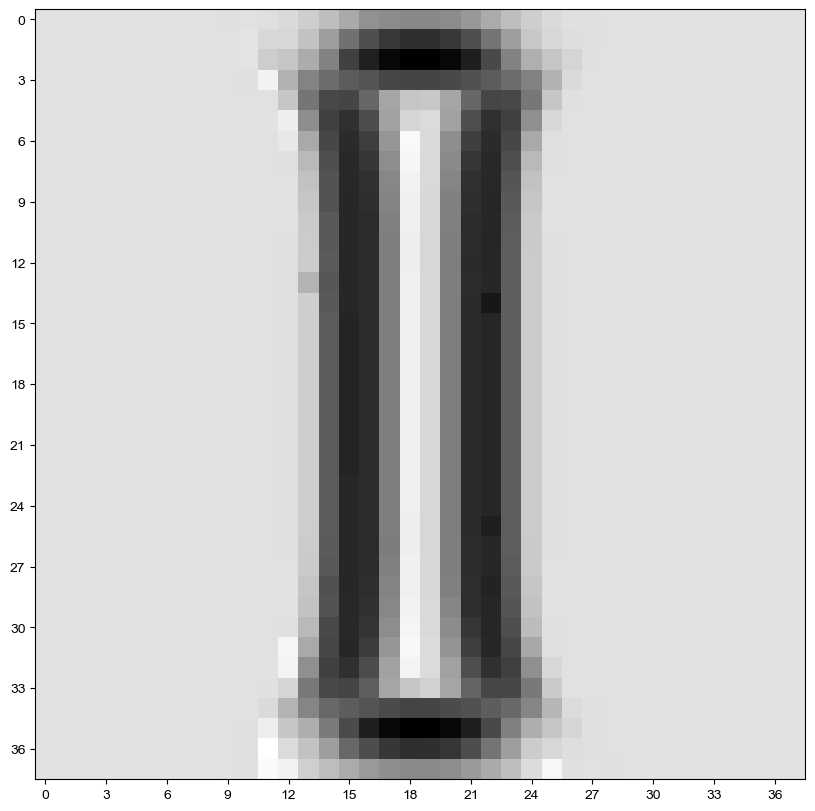

C:\Users\haloe\Documents\CodeWriting\4Denoise\helpers\fourdenoise.py:2936: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.mean(self.array, axis=(0,1))*detector_mask), cmap='turbo',)


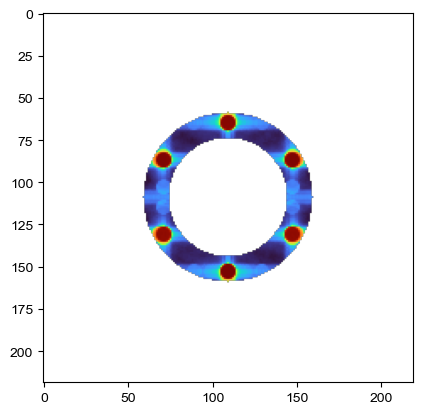

In [21]:
plt.figure(figsize=(10,10))
ripple_dataset.get_virtualImage(r_minor=35, r_major=50, plotMask=True, grid=False)
plt.show()

Generate 5D dataset using the infinite-dose *abTEM*-generated 4D dataset, with the first dimension varying the dose level.

In [442]:
# Parameters
area = np.pi * 14.232312202453613**2 / 4 # FWHM area in angstroms, calculated from `dp_flat` diffraction pattern
doses = np.array([1e4, 1e3, 1e2, 1e1]) * area # electrons (counts in diffraction pattern)
num_doses = len(doses)

In [443]:
# Number of electrons per diffraction pattern according to each dose level
doses

array([1590892.39307473,  159089.23930747,   15908.92393075,
          1590.89239307])

In [315]:
ry, rx = ripple_dataset.shape[:2]
ky, kx = 128, 128 # Experimental diffraction pattern shape

# Initialize simulated 5D dataset
noisy_datasets_high_to_low = np.zeros((num_doses, ry, rx, ky, kx), dtype=np.float32)

# Cropping parameters
new_kdist = 7.04*219/7.64
crop_distance = (219 - new_kdist)/2

for i in tqdm(range(ry)):
    for j in range(rx):

        # Obtain infinite dose diffraction pattern
        # dp = ripple_dataset.get_dp(i, j)
        dp = ReciprocalSpace(dataset_list[i*ry + j].array)
        
        # Crop and resize diffraction pattern to match simulation data
        dp = dp.crop(
                     # kylim=(crop_distance, new_kdist + crop_distance), 
                     # kxlim=(crop_distance, new_kdist + crop_distance),
                     kshape=(ky, kx)
                    ).array
        
        dp /= dp.sum()       
        
        # Apply multiple dose levels
        for idx, dose in enumerate(doses):

            # Apply Poisson noise for the given dose
            dp_noisy = np.random.poisson(dp*dose)
        
            # Store the obtained diffraction pattern
            noisy_datasets_high_to_low[idx, i, j] = dp_noisy

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


In [492]:
noisy_datasets_high_to_low.shape

(6, 38, 38, 128, 128)

### Data processing step: Bragg peak center-of-mass finding

We need reference coordinates to enable **center-of-mass** finding, to do this, we can find the peaks using a manual option to select the peaks of interest (other methods are available but not implemented in this Jupyter notebook).

#### Finding peaks via `select_peaks`

The option below opens a window where peaks are directly clicked, as shown below (the button "**ENTER**" must be clicked or the kernel will keep running regardless of whether the window is closed. This will be fixed in a latter release of 4Denoise)

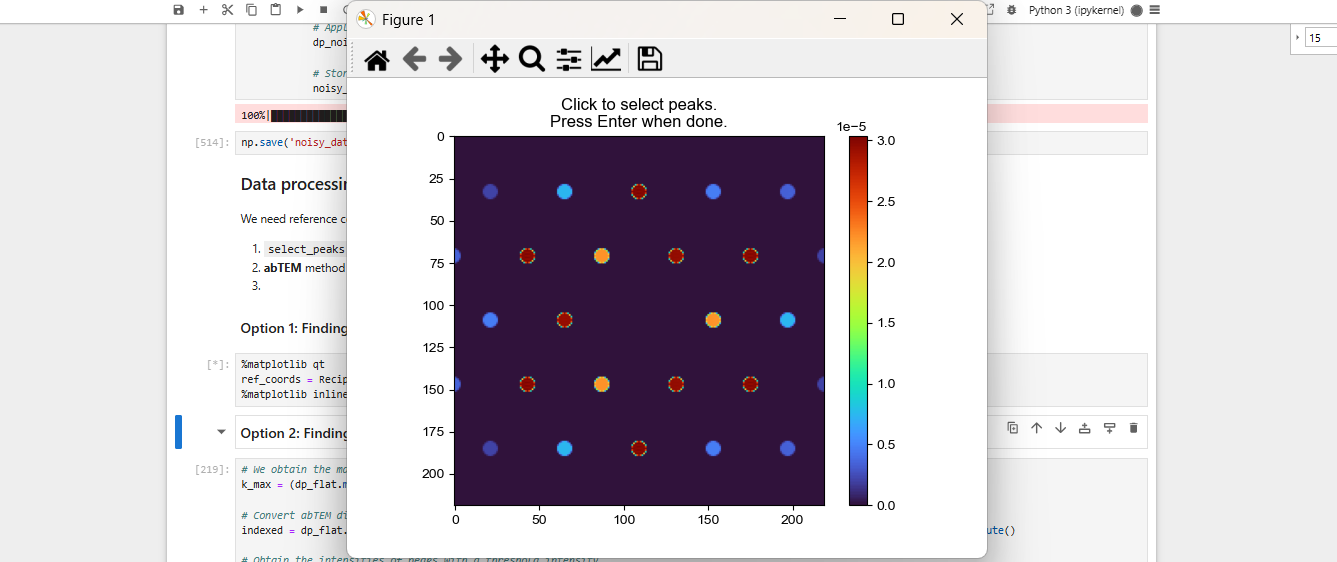

In [317]:
# Obtain a representative "flat" diffraction pattern from the data
ripple_flat_region = HyperData(ripple_dataset).get_dp(y=(0,38), x=(0,5))

# Here transform the reference ripple (flat region) to match experimental one
ripple_flat_region_cropped = ripple_flat_region.crop(
                                                     # kylim=(crop_distance, new_kdist + crop_distance), 
                                                     # kxlim=(crop_distance, new_kdist + crop_distance), 
                                                     kshape=(128,128))

In [318]:
%matplotlib qt
ref_coords = ripple_flat_region_cropped.select_peaks(cmap='turbo',)
%matplotlib inline

In [319]:
ref_coords

array([[ 14.87662338,  63.15367965],
       [ 39.11904762, 104.71212121],
       [ 86.91125541, 104.71212121],
       [111.5       ,  63.5       ],
       [ 87.25757576,  22.28787879],
       [ 39.11904762,  22.28787879]])

Otherwise, use the approximate coordinates below directly:

In [61]:
ref_coords = np.array([[ 22.14935065,  87.3961039 ],
                       [ 63.01515152, 111.29220779],
                       [104.91991342,  87.74242424],
                       [104.57359307,  39.6038961 ],
                       [ 63.01515152,  15.01515152],
                       [ 21.8030303 ,  38.91125541]])

**Note:** Below, we add a small number (e.g., 1e-10) to all pixels of the dataset to allow for center-of-mass calculations (this will be fixed in a latter release of 4Denoise package)

In [320]:
# Compute centers of mass for 4D dataset
all_centers = np.zeros((6, ry,  rx, 6, 2))

for i in range(num_doses):
    centers = HyperData(noisy_datasets_high_to_low[i]+1e-10).get_centers(r=4.75, ref_coords=ref_coords, method='CoM')
    all_centers[i] = centers

Computing centers (4D): 100%|██████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.63it/s]


### Data processing step: Bragg peak intensity integration

Compute intensities for each dose map

In [321]:
# Compute intensities for all diffraciton patterns in 4D dataset
ny, nx = ripple_map.shape
all_intensities = np.zeros((4, ny,  nx, 6))

for i in range(num_doses):
    
    # Instantiate 4D data as a HyperData object
    dataset = HyperData(noisy_datasets_high_to_low[i])

    # Compute intensities
    intensities = dataset.get_intensities(r=4.75, centers=all_centers[i], method='CoM')

    # For normalization
    flat_intensities = dataset.get_dp((0,38), (0,7)).get_intensities(r=4.75, centers=ref_coords, method='CoM')

    # Store
    all_intensities[i] = intensities/flat_intensities

Calculating intensities: 100%|█████████████████████████████████████████████████████████| 38/38 [00:03<00:00, 11.62it/s]


Visualize the same diffraction pattern (randomly picked) at different dose levels

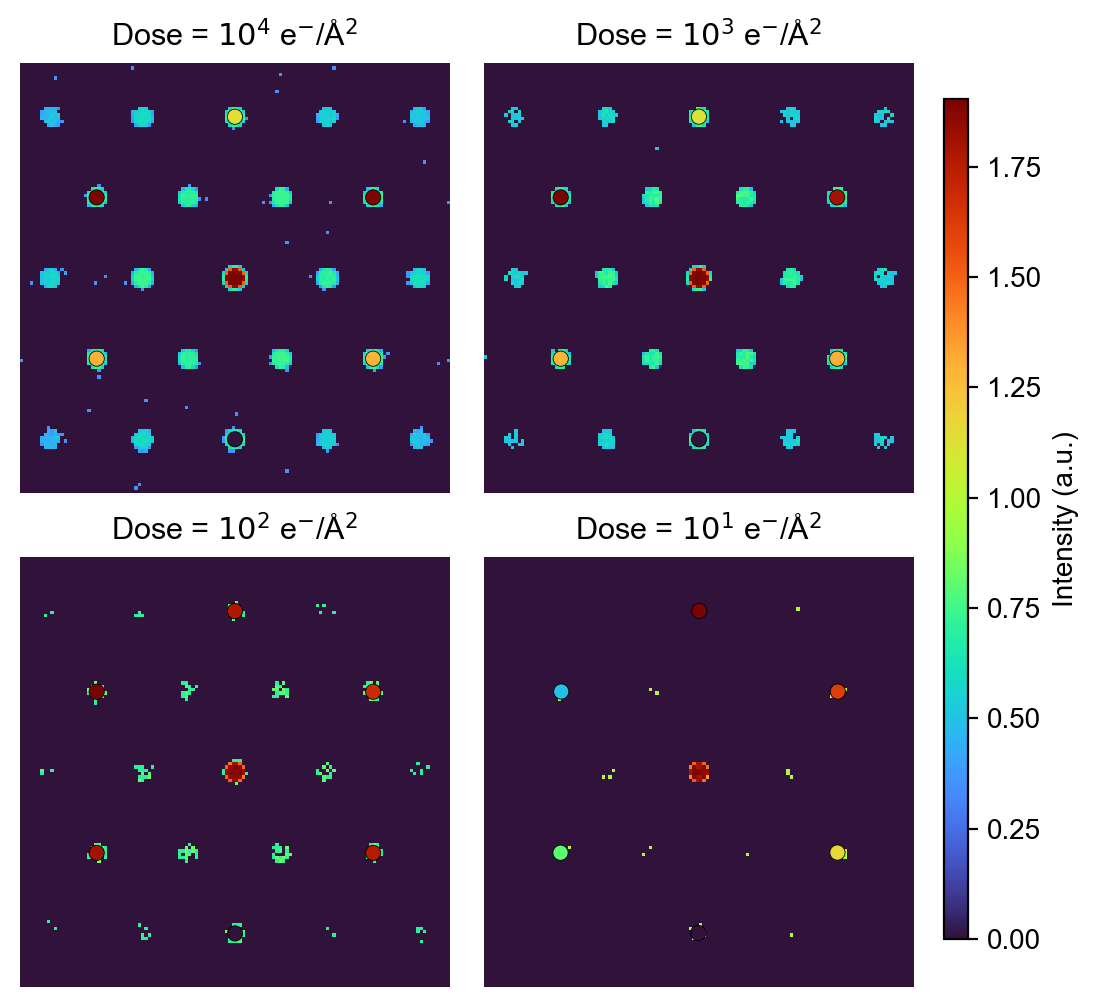

In [447]:
# ---- parameters ----
a, b = np.random.randint(0, 38), np.random.randint(0, 38)
dose_labels = [r"$10^4$", r"$10^3$", r"$10^2$", r"$10^1$"]
gamma = 0.15   # contrast enhancement
cmap_name = "turbo"
dot_size = 30
# ---------------------

fig, axs = plt.subplots(2, 2, figsize=(6, 6), dpi=200)
axs = axs.ravel()

for i, ax in enumerate(axs):
    dp = noisy_datasets_high_to_low[i+2, a, b]

    # Local normalization per pattern (not across all)
    vmin_i, vmax_i = np.min(dp), np.max(dp)

    im = ax.imshow(dp**gamma, cmap=cmap_name, vmin=vmin_i**gamma, vmax=vmax_i**gamma)

    # Overlay spot centers colored by intensity
    ax.scatter(
        all_centers[i, a, b, :, 1],
        all_centers[i, a, b, :, 0],
        c=all_intensities[i, a, b, :],
        cmap=cmap_name,
        s=dot_size,
        edgecolors="k",
        linewidths=0.3
    )

    ax.set_title(f"Dose = {dose_labels[i]} e$^{{-}}$/Å$^2$", fontsize=11)
    ax.axis("off")

# Shared colorbar (from last image)
fig.subplots_adjust(right=0.88, wspace=0.05, hspace=0.15)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Intensity (a.u.)")

plt.show()


### Compute tilt map for each dose level map

In [83]:
model_ints_array = np.load('./sim_ints_MoSe2_many.npy')

In [323]:
all_tilts = np.zeros((4, ry, rx, 2))

for i in range(num_doses):
    
    all_tilts[i] = get_tilts(intensity_array=all_intensities[i],
                             show_result=False,
                             method='grid_search', 
                             loss='euclidean_distance', 
                             simDataArray=model_ints_array,)

Finding optimal (phi, theta): 100%|████████████████████████████████████████████████████| 38/38 [02:59<00:00,  4.72s/it]


In [567]:
np.save('all_tilts.npy', all_tilts)

In [320]:
all_tilts = np.load('all_tilts.npy')

In [414]:
all_grads.shape

(6, 38, 38, 2)

Automatically find the required rotation angle `rot_angle` that aligns the x- and y-gradients appropriately with the x and y axes. This can be done manually by verifying that the gradients are properly aligned using `plt.imshow(grads[...,0])` (which should display the x-gradients, regardless of sign errors).

In [ ]:
# sums = np.zeros(181)
for q in range(181):
            
    grads = get_gradients(all_tilts[0], 
                          rot_angle=q,       # 'rot_angle' is for use to specify the positive/negative X and Y directions 
                          show_result=False, 
                          invertY=True,      # Make sure that positive direction of y-gradient is out-of-screen downward
                          invertX=True,      # Make sure that positive direction of x-gradient is out-of-screen going to the right
                          cbar_fraction=0.031) 

    # We seek to find the `rot_angle` which minimizes the sum of the perpendicular gradients
    sums[q] = np.sum(np.abs(grads[10:28,:,1]))

Obtain all gradient maps

In [472]:
all_grads = np.zeros((4, ry, rx, 2))

for i in range(num_doses):
    
    all_grads[i] = get_gradients(all_tilts[i], 
                                  rot_angle=np.argmin(sums),    # 'rot_angle' is for use to specify the positive/negative X and Y directions 
                                  show_result=False, 
                                  invertY=False,                # Make sure that positive direction of y-gradient is out-of-screen downward
                                  invertX=False,                # Make sure that positive direction of x-gradient is out-of-screen going to the right
                                  cbar_fraction=0.031) 

Below, we confirm that the x-gradient is aligned with the left and right ripple walls.

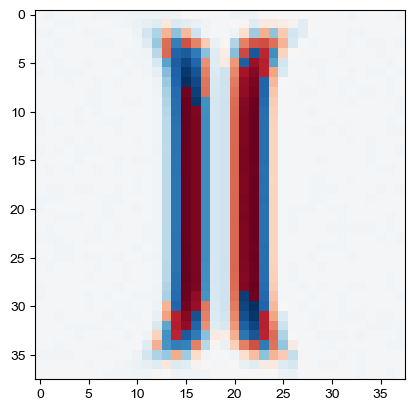

In [433]:
plt.imshow(all_grads[0,:,:,0], cmap='RdBu')

In [ ]:
all_hmaps = np.zeros(4, ny, nx)

for i in range(4):

        hmap = reconstruct_height(xGrad=all_grads[i,:,:,0], yGrad=all_grads[i,:,:,1], 
                                  y_bds_flat=(10,28), 
                                  x_bds_flat=(0,13), 
                                  iterations=80, 
                                  threshold_percent=0.3, 
                                  max_window_size=5, 
                                  plot=False)[0]
    
        hmap -= np.mean(hmap[:37,:13])

In [34]:
np.save('all_hmaps.npy', all_hmaps)

In [35]:
ripple_map = np.load('geometric_ripple.npy')

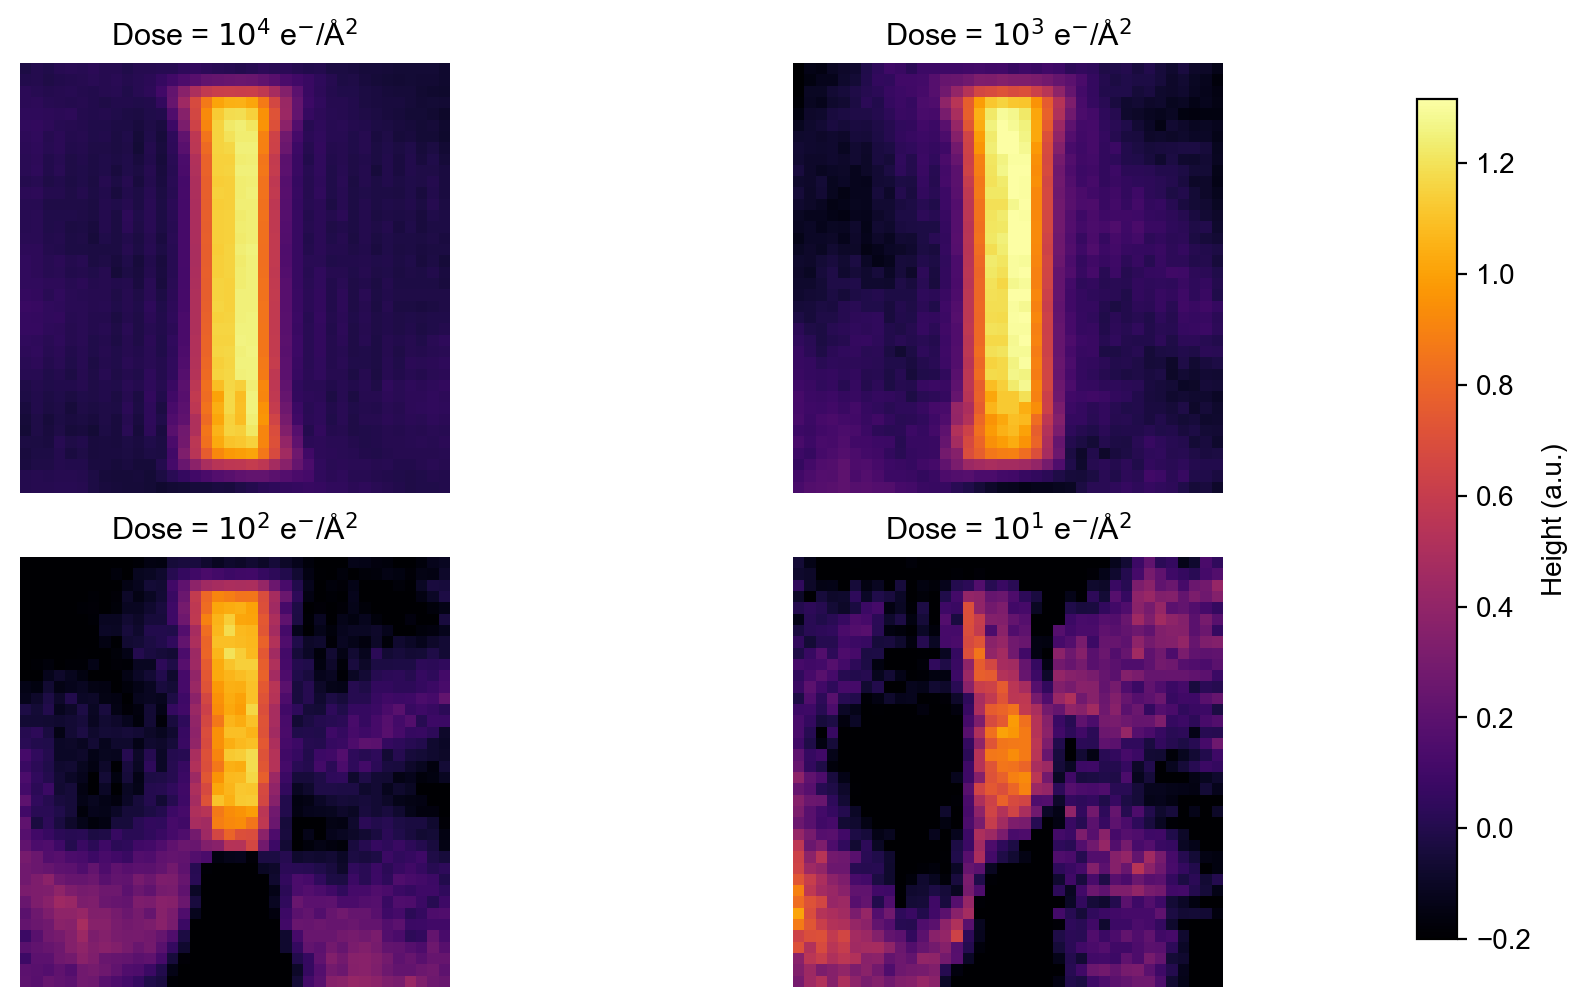

In [475]:
dose_labels = [r"$10^4$", r"$10^3$", r"$10^2$", r"$10^1$"]
cmap_name = "inferno"

fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=200)
axs = axs.ravel()

# Compute global color range across all height maps for consistent contrast
vmin = min(np.nanmin(all_hmaps[i]) for i in range(4))*0.95
vmax = max(np.nanmax(all_hmaps[i]) for i in range(4))*0.95

for i, ax in enumerate(axs):
    im = ax.imshow(all_hmaps[i], cmap=cmap_name, vmin=-0.2, vmax=vmax)
    ax.set_title(f"Dose = {dose_labels[i]} e$^{{-}}$/Å$^2$", fontsize=11)
    ax.axis("off")

# Shared colorbar
fig.subplots_adjust(right=0.88, wspace=0.05, hspace=0.15)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Height (a.u.)")

plt.show(


### We also obtain the height map for the infinite-dose version of the ripple data

In [120]:
ripple_data = np.load('simulated_4d_dataset_highRes.npy')

In [121]:
ripple_data = HyperData(ripple_data).crop(
                                          kshape=(128,128)
                                         )

In [122]:
flat_intensities = ripple_flat_region_cropped.get_intensities(r=5, method='CoM', ref_coords=ref_coords,)

In [123]:
# Compute centers of mass for 4D dataset
centers_inf = ripple_data.get_centers(r=4.75, ref_coords=ref_coords, method='CoM')

# Compute intensities for all diffraciton patterns in 4D dataset
intensities_inf = ripple_data.get_intensities(r=4.75, centers=centers_inf,)

Calculating intensities: 100%|█████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 74.03it/s]


In [124]:
# Normalize as required for the height-mapping algorithm
intensities_inf /= flat_intensities

In [343]:
options= ['load', 'generate']
option = options[0] # [0] to load or [1] to generate data

if option in options:
    if option == 'load':
        model_ints_array = np.load('./sim_ints_MoSe2_many.npy')
    else:
        model_ints_array = generate_library(phi_range=(0,360), num_phis=721,       # Specify range and number of values simulated    
                                      theta_range=(0,25), num_thetas=1251,     # Specify range and number of values simulated        
                                      save=True, fname='sim_ints_MoSe2_many.npy', # Optionaly, save the generated library
                                      material='MoSe2', a=3.32, order=2,     # Kinematic diffraction simulation arguments
                                      normalization='flat_max', keV=80,      # Kinematic diffraction simulation arguments
                                     )
        
else:
    print("To either load or generate simulation data, you must assign the right option.")

Finding optimal (phi, theta): 100%|████████████████████████████████████████████████████| 38/38 [00:57<00:00,  1.51s/it]


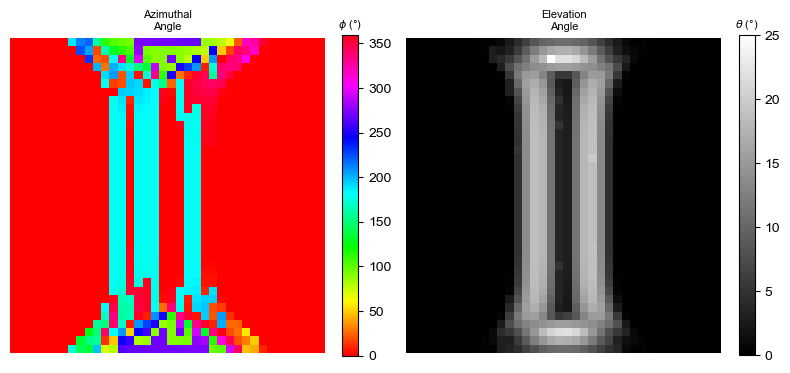

In [125]:
tilts = get_tilts(intensity_array=intensities_inf,
                  show_result=True, figsize=(8, 8),
                  method='grid_search', 
                  loss='euclidean_distance', 
                  simDataArray=model_ints_array,)

We show the gradient maps according to the solution found by `get_tilts`. Note that the sign of the gradient is fixed during the reconstruction.

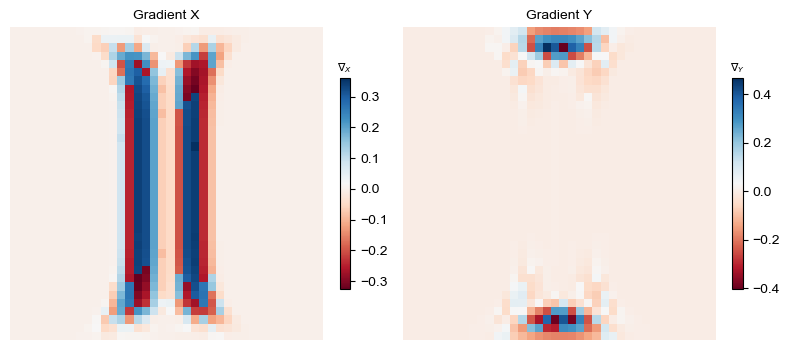

In [126]:
grads = get_gradients(tilts, 
                      rot_angle=-90, # 'rot_angle' is for use to specify the positive/negative X and Y directions 
                      show_result=True, invertY=True, invertX=True,
                      cbar_fraction=0.031) 

In [127]:
inf_dose = reconstruct_height(xGrad=grads[:,:,0], yGrad=grads[:,:,1], 
                              y_bds_flat=(10,28), 
                              x_bds_flat=(0,13), 
                              iterations=80, 
                              threshold_percent=0.6, 
                              max_window_size=5, 
                              plot=False)[0]

C:\Users\haloe\Documents\CodeWriting\4Denoise\helpers\fourdenoise.py:1153: RuntimeWarning: divide by zero encountered in reciprocal
  q2inv = np.reciprocal(q2a)
Reconstructing height: 100%|███████████████████████████████████████████████████████████| 80/80 [00:07<00:00, 11.06it/s]


In [437]:
np.save('inf_dose.npy', inf_dose)

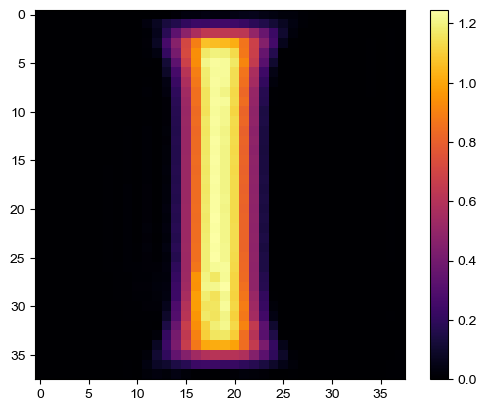

In [436]:
plt.imshow(inf_dose, cmap='inferno', vmin=0)
plt.colorbar()
plt.show()

We visualize all reconstructions in 3D

In [508]:
all_hmaps.shape

(6, 38, 38)

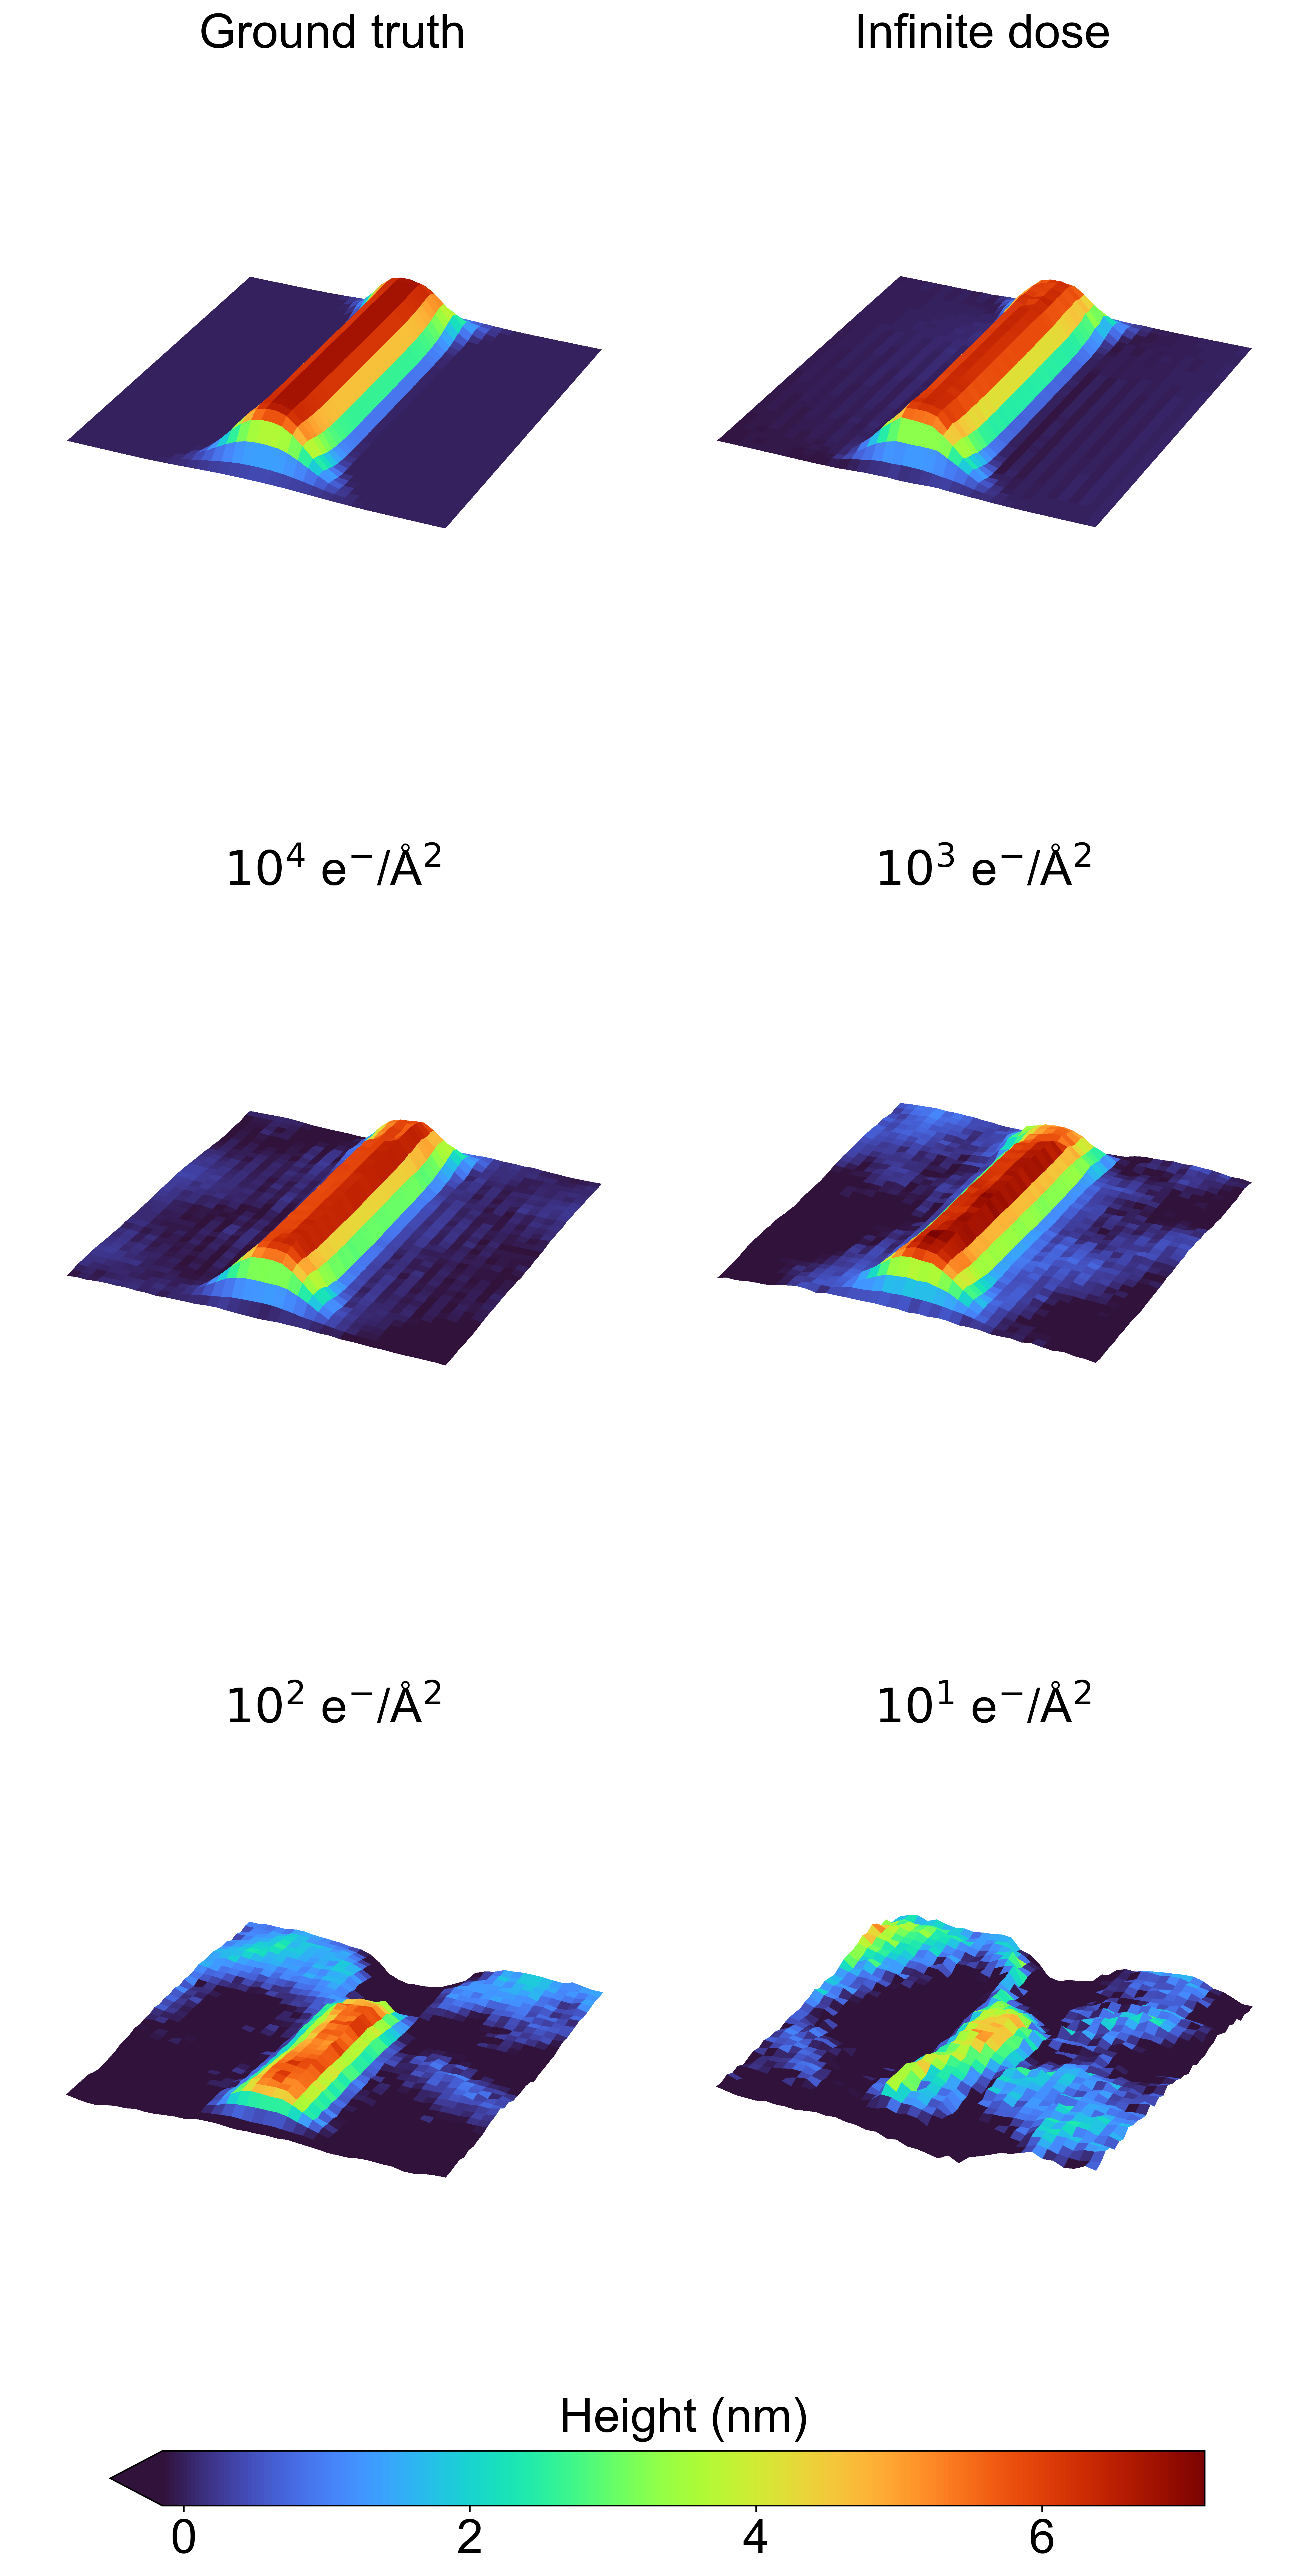

In [510]:
import matplotlib as mpl

height_scale_nm_per_px = 5.152    # convert heights: nm per pixel
z_exag      = 15.0 * 2.5/5.152    # vertical exaggeration (visualization only)
elev, azim  = 27.5, -65           # 3D camera view
cmap_name   = "turbo"             # colormap for heights

title_size  = 25                  # subplot title fontsize
title_pad   = 2                   # distance from subplot (points)
axes_off    = True                # hide axes/frames/ticks on each 3D panel

# spacing/margins
wspace, hspace = 0.02, 0.02
margins = dict(left=0.03, right=0.97, bottom=0.08, top=0.98)

# colorbar stuff
cbar_title        = "Height (nm)"
cbar_title_size   = 25
cbar_title_pad    = 10          # gap bet. bar and its title
cbar_tick_size    = 25
cbar_fraction     = 0.05        # colorbar thickness (frac)
cbar_pad          = 0.03        # gap bet.  panels/colorbar
cbar_shrink       = 0.85        # length of colorbar (frac of fig)

maps = [
    ripple_map,                 
    inf_dose,                               
    all_hmaps[0],               
    all_hmaps[1],               
    all_hmaps[2],               
    all_hmaps[3],               
]

titles = [
    "Ground truth",
    "Infinite dose",
    r"$10^4$ e$^{-}$/Å$^2$",
    r"$10^3$ e$^{-}$/Å$^2$",
    r"$10^2$ e$^{-}$/Å$^2$",
    r"$10^1$ e$^{-}$/Å$^2$",
]

# Coordinates
A, B = ripple_map.shape
y = np.arange(A)
x = np.arange(B)
X, Y = np.meshgrid(x, y, indexing="xy")

try:
    cmap = mpl.colormaps.get_cmap(cmap_name)
except Exception:
    cmap = mpl.colormaps.get_cmap("turbo")

# global color scale 
stack_arr = np.stack(maps, axis=0)                       
stack_nm = stack_arr*height_scale_nm_per_px              # convert to nm
data_max = float(np.nanmax(stack_nm))
norm = mpl.colors.Normalize(vmin=-0.15, vmax=data_max)

# Figure and 3D axes
fig = plt.figure(figsize=(10, 22), dpi=500)
axs = [fig.add_subplot(3, 2, i + 1, projection="3d") for i in range(6)]

def hide_3d_axes(ax):
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel(""); ax.set_ylabel(""); ax.set_zlabel("")
    ax.grid(False)
    # Make panes/inset lines fully transparent
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.set_edgecolor((1, 1, 1, 0))
        axis.pane.set_facecolor((1, 1, 1, 0))
        axis.line.set_color((1, 1, 1, 0))
    if axes_off:
        ax.set_axis_off()

# Plot panels
for ax, Z_px, title in zip(axs, maps, titles):
    Z_nm = Z_px * height_scale_nm_per_px       # <-- conversion here (nm)
    facecolors = cmap(norm(Z_nm))              # color by *true* (unexaggerated) nm
    Zplot = Z_nm * z_exag                      # exaggerate Z only for display

    ax.plot_surface(
        X, Y, Zplot,
        facecolors=facecolors,
        rstride=1, cstride=1,
        linewidth=0, antialiased=False, shade=False
    )
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title, fontsize=title_size, pad=title_pad)
    ax.set_box_aspect((B, A, 0.1 * max(data_max, 1e-12) * z_exag))
    hide_3d_axes(ax)

# Tighten spacing between subplots
fig.subplots_adjust(wspace=wspace, hspace=hspace, **margins)

# Shared colorbar at the bottom (horizontal), label *above*, ticks *below*
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = fig.colorbar(
    mappable, ax=axs, orientation="horizontal", location="bottom",
    fraction=cbar_fraction, pad=cbar_pad, shrink=cbar_shrink, extend="min"
)

# Put the title above the bar; keep ticks below
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.set_xlabel(cbar_title, fontsize=cbar_title_size, labelpad=cbar_title_pad)
cbar.ax.tick_params(axis='x', labelsize=cbar_tick_size)

plt.show()

We plot the error on the ripple region of the dataset (exclude flat region as much as possible)

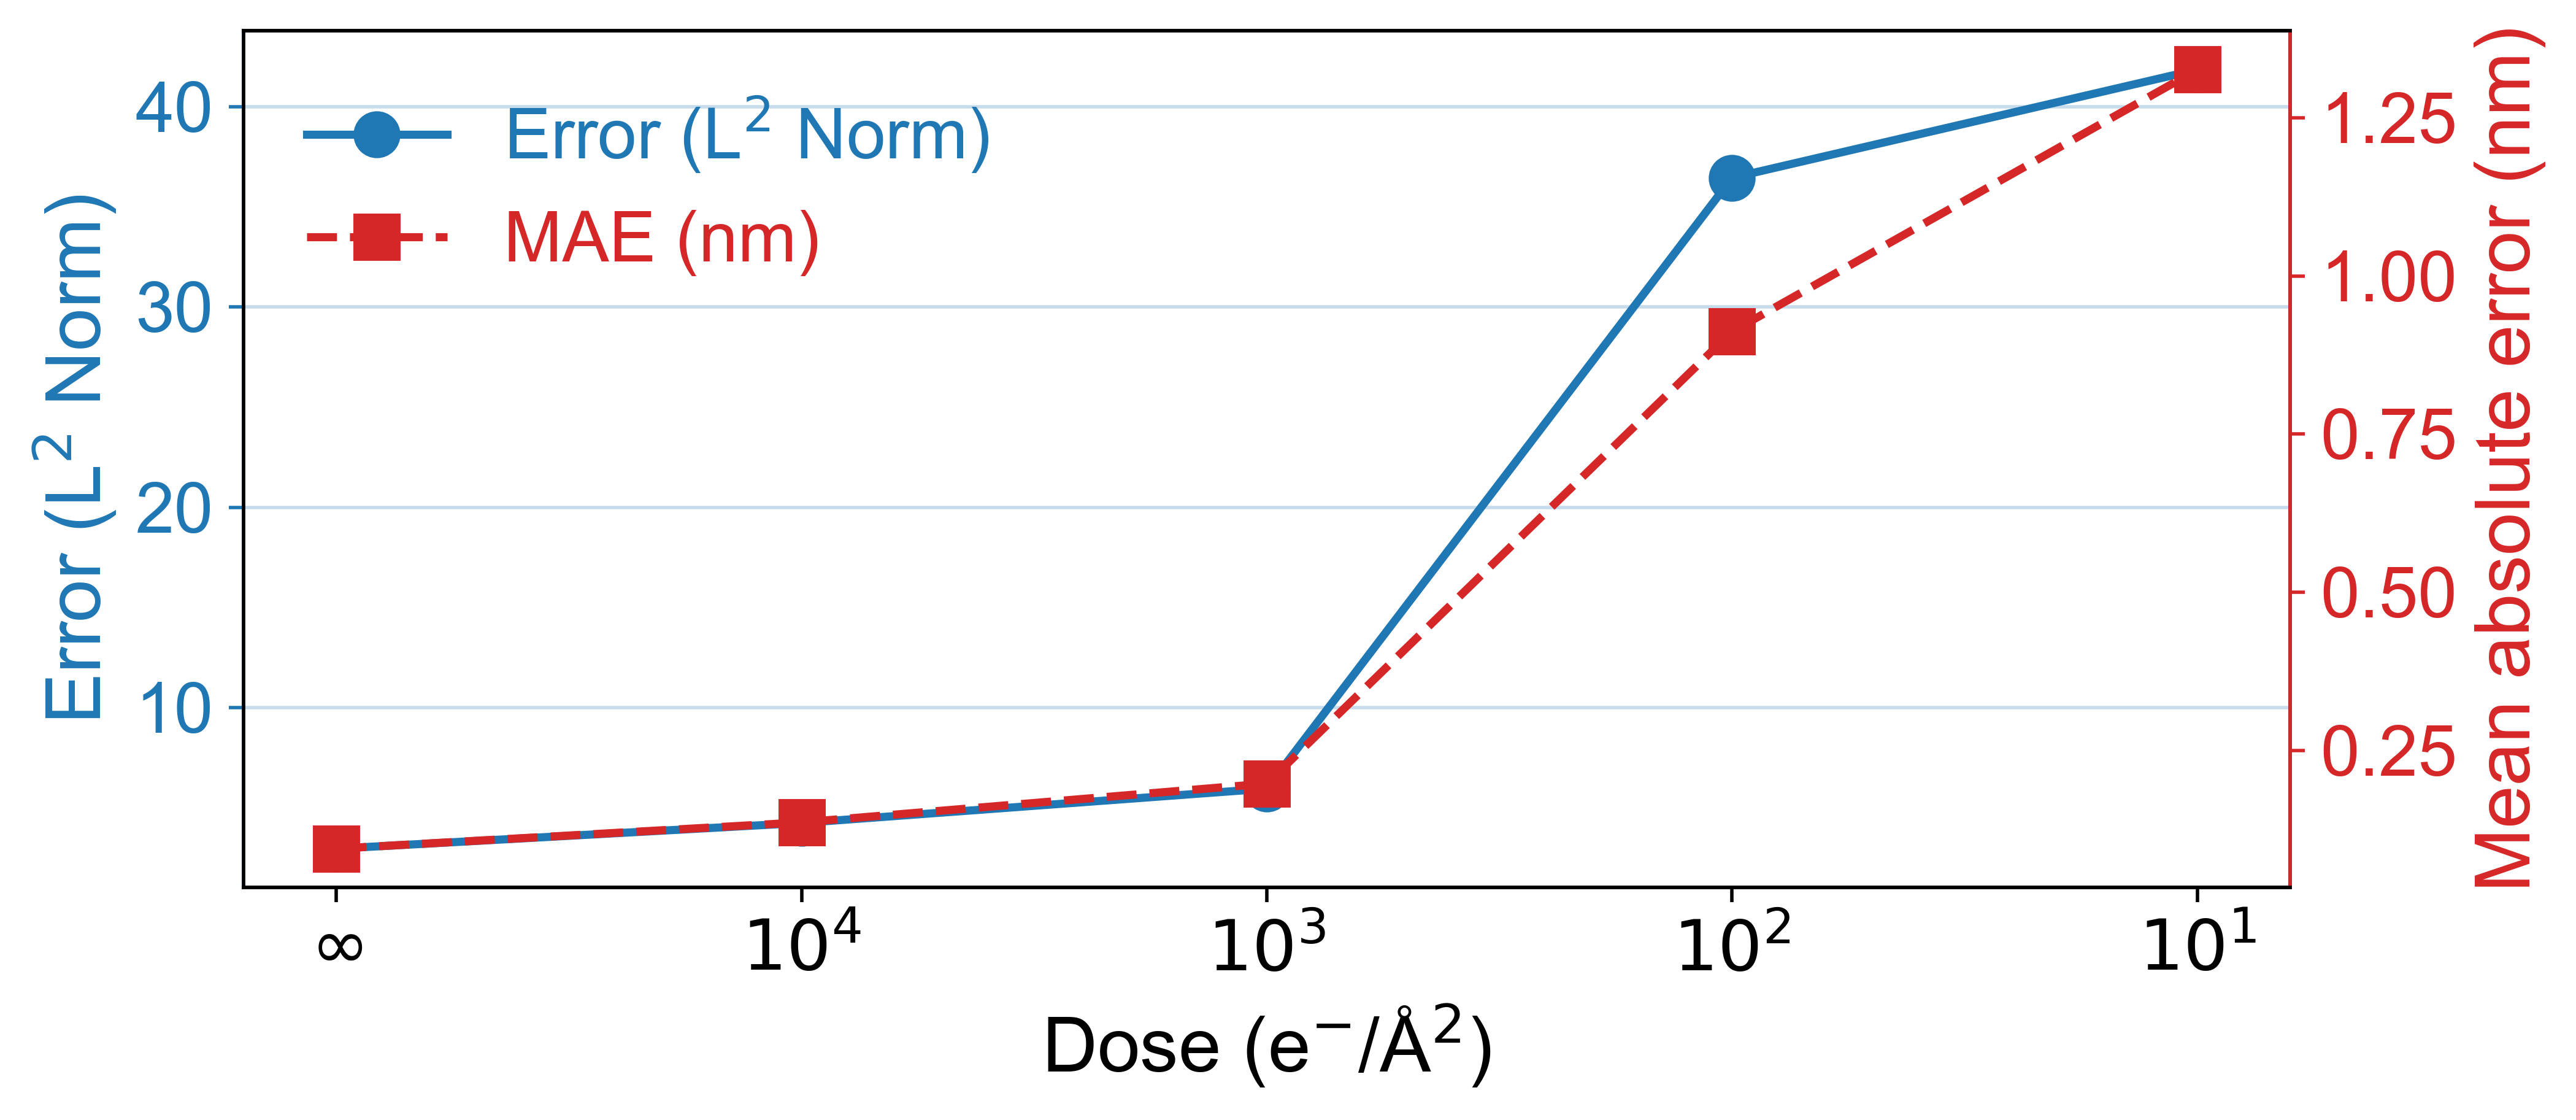

Dose, L2 Norm(Error) [nm·sqrt(px in ROI [:,13:28])], MAE(nm)
$\infty$: 2.9589, 0.0945361
$10^4$: 4.24149, 0.136088
$10^3$: 5.95433, 0.197432
$10^2$: 36.4509, 0.91199
$10^1$: 41.8483, 1.32608


In [458]:
def masked_diff_roi(a, b, roi):
    """Flattened (a - b) on ROI with shared finite mask."""
    a_roi = a[roi]; b_roi = b[roi]
    mask = np.isfinite(a_roi) & np.isfinite(b_roi)
    return (a_roi[mask] - b_roi[mask]).ravel()

def l2_error_nm(a_nm, b_nm, roi):
    d = masked_diff_roi(a_nm, b_nm, roi)
    return np.linalg.norm(d) if d.size else np.nan   # nm·sqrt(px_in_ROI)

def mae_nm(a_nm, b_nm, roi):
    d = masked_diff_roi(a_nm, b_nm, roi)
    return np.mean(np.abs(d)) if d.size else np.nan  # nm
    
height_scale_nm_per_px = 2.5   # convert height px to nm
tick_label_size  = 11*1.5
axis_label_size  = 12*1.5
legend_size      = 11*1.5
marker_size      = 10
line_width       = 1.9
x_label = r"Dose (e$^{-}$/Å$^2$)"
grid_y = True

# ROI
roi_col_start, roi_col_stop = 13, 28 

dose_labels_math = [r"$\infty$", r"$10^4$", r"$10^3$", r"$10^2$", r"$10^1$", ]
dose_maps_px = [inf_dose] + [all_hmaps[i+2] for i in range(4)]

# Convert to nm
GT_nm = ripple_map * height_scale_nm_per_px
dose_maps_nm = [m * height_scale_nm_per_px for m in dose_maps_px]

# define ROI based on input width
A, B = GT_nm.shape
start = max(0, min(B, roi_col_start))
stop  = max(start + 1, min(B, roi_col_stop))  # ensure at least 1 column
roi = (slice(None), slice(start, stop))       # [:, start:stop)

# compute metrics on ROI
norm_vals = [l2_error_nm(m, GT_nm, roi) for m in dose_maps_nm]  # nm·sqrt(px in ROI)
mae_vals  = [mae_nm(m, GT_nm, roi)       for m in dose_maps_nm] # nm

fig, ax_left = plt.subplots(figsize=(8.5, 3.75), dpi=500)
x = np.arange(len(dose_labels_math))
roi_text = f"ROI [:,{start}:{stop}]"

# Left axis: L2 Norm(Error) — BLUE
left_color  = "tab:blue"
right_color = "tab:red"

ln1 = ax_left.plot(
    x, norm_vals, marker="o", linewidth=line_width, markersize=marker_size,
    color=left_color, label=r"Error (L$^2$ Norm)"
)[0]
ax_left.set_xlabel(x_label, fontsize=axis_label_size)
ax_left.set_xticks(x, dose_labels_math, fontsize=tick_label_size)
ax_left.set_ylabel(r"Error (L$^2$ Norm)",
                   fontsize=axis_label_size, color=left_color)
ax_left.tick_params(axis='y', labelsize=tick_label_size, colors=left_color)
ax_left.spines['left'].set_color(left_color)
if grid_y:
    ax_left.grid(True, which="major", axis="y", alpha=0.25, color=left_color)

# Right axis: MAE — RED
ax_right = ax_left.twinx()
ln2 = ax_right.plot(
    x, mae_vals, marker="s", linestyle="--", linewidth=line_width, markersize=marker_size,
    color=right_color, label="MAE (nm)"
)[0]
ax_right.set_ylabel("Mean absolute error (nm)",
                    fontsize=axis_label_size, color=right_color)
ax_right.tick_params(axis='y', labelsize=tick_label_size, colors=right_color)
ax_right.spines['right'].set_color(right_color)

# Shared legend with colored entries
lines = [ln1, ln2]
labels = [l.get_label() for l in lines]
leg = ax_left.legend(lines, labels, loc="best", fontsize=legend_size, frameon=False)
for txt, col in zip(leg.get_texts(), [left_color, right_color]):
    txt.set_color(col)

fig.tight_layout()
plt.show()

# Numeric log
print(f"Dose, L2 Norm(Error) [nm·sqrt(px in {roi_text})], MAE(nm)")
for lbl, nval, mval in zip(dose_labels_math, norm_vals, mae_vals):
    print(f"{lbl:>6s}: {nval:.6g}, {mval:.6g}")
